# Import libraries

In [366]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [16, 6]
pd.set_option('display.max_columns', None)
#from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

# Read files into pandas dataframe and merge files
The first 5 rows of data in Train.csv are shown.  
There are 14 variables, of which "stock_distributed" is the dependant variable (target variable).

In [462]:
df = pd.read_csv("https://raw.githubusercontent.com/chencba/ContracetivesConsumptionPrediction/main/Train.csv")
df[:5]

year  month            region    district site_code product_code  \
0  2019      1  INDENIE-DJUABLIN  ABENGOUROU     C4001      AS27134   
1  2019      1  INDENIE-DJUABLIN  ABENGOUROU     C4001      AS27132   
2  2019      1  INDENIE-DJUABLIN  ABENGOUROU     C4001      AS27000   
3  2019      1  INDENIE-DJUABLIN  ABENGOUROU     C4001      AS27137   
4  2019      1  INDENIE-DJUABLIN  ABENGOUROU     C4001      AS27138   

   stock_initial  stock_received  stock_distributed  stock_adjustment  \
0             75               0                 21               -54   
1              3               0                  3                 0   
2              0              75                 22                 0   
3              2               0                  0                 0   
4             45               0                  2                 0   

   stock_end  average_monthly_consumption  stock_stockout_days  stock_ordered  
0          0                           18                    0          100.0  
1          0                            2                    0           10.0  
2         53                            9                    0            0.0  
3          2                            0                    0            0.0  
4         43                            1                    0            0.0

### Merge the dataframe with the product csv file
Join the two tables by "product_code". Now we have two new columns - "product_type" and "product_name".

### Merge the dataframe with the service_delivery_site_data csv file
Join the two tables by "site_code".  Now we have three new columns - "site_type", "site_latitude" and "site_longitude".

In [463]:
product = pd.read_csv("https://raw.githubusercontent.com/chencba/ContracetivesConsumptionPrediction/main/product.csv")
df = df.merge(product, on = "product_code")

site = pd.read_csv("https://raw.githubusercontent.com/chencba/ContracetivesConsumptionPrediction/main/service_delivery_site_data.csv")
df = df.merge(site, on = "site_code")

df.drop(["site_region", "site_district"], axis = 1, inplace = True)

df[:5]

year  month            region    district site_code product_code  \
0  2019      1  INDENIE-DJUABLIN  ABENGOUROU     C4001      AS27134   
1  2019      2  INDENIE-DJUABLIN  ABENGOUROU     C4001      AS27134   
2  2019      3  INDENIE-DJUABLIN  ABENGOUROU     C4001      AS27134   
3  2019      4  INDENIE-DJUABLIN  ABENGOUROU     C4001      AS27134   
4  2019      5  INDENIE-DJUABLIN  ABENGOUROU     C4001      AS27134   

   stock_initial  stock_received  stock_distributed  stock_adjustment  \
0             75               0                 21               -54   
1              0               0                  0                 0   
2              0             100                  0                 0   
3            100               0                  2                 0   
4             98               0                 31                 0   

   stock_end  average_monthly_consumption  stock_stockout_days  stock_ordered  \
0          0                           18                    0          100.0   
1          0                           18                    0          100.0   
2        100                            7                    0            0.0   
3         98                            1                    0            0.0   
4         67                           11                    0            0.0   

               product_type                              product_name  \
0  Injectable Contraceptive  NORISTERAT 200 MG AMP INJ BTE/100 BOITE    
1  Injectable Contraceptive  NORISTERAT 200 MG AMP INJ BTE/100 BOITE    
2  Injectable Contraceptive  NORISTERAT 200 MG AMP INJ BTE/100 BOITE    
3  Injectable Contraceptive  NORISTERAT 200 MG AMP INJ BTE/100 BOITE    
4  Injectable Contraceptive  NORISTERAT 200 MG AMP INJ BTE/100 BOITE    

  site_type  site_latitude  site_longitude  
0  Hospital       6.730937       -3.483863  
1  Hospital       6.730937       -3.483863  
2  Hospital       6.730937       -3.483863  
3  Hospital       6.730937       -3.483863  
4  Hospital       6.730937       -3.483863

### Read submission file

In [369]:
submissions = pd.read_csv("https://raw.githubusercontent.com/chencba/ContracetivesConsumptionPrediction/main/SampleSubmission.csv")
submissions[:5]

ID  prediction
0  2019 X 7 X C4001 X AS21126           0
1  2019 X 7 X C4001 X AS27134           0
2  2019 X 7 X C4001 X AS27132           0
3  2019 X 7 X C4001 X AS27000           0
4  2019 X 7 X C4001 X AS27137           0

# Part 1 - Data Wrangling

## 1.1 Read the general information from the dataframe
Only column "stock_ordered" has fewer rows (34990) than other columns (35753).   
Data types for "year" and "month" columns need to be changed from int to str.

In [370]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35753 entries, 0 to 35752
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   year                         35753 non-null  int64  
 1   month                        35753 non-null  int64  
 2   region                       35753 non-null  object 
 3   district                     35753 non-null  object 
 4   site_code                    35753 non-null  object 
 5   product_code                 35753 non-null  object 
 6   stock_initial                35753 non-null  int64  
 7   stock_received               35753 non-null  int64  
 8   stock_distributed            35753 non-null  int64  
 9   stock_adjustment             35753 non-null  int64  
 10  stock_end                    35753 non-null  int64  
 11  average_monthly_consumption  35753 non-null  int64  
 12  stock_stockout_days          35753 non-null  int64  
 13  stock_ordered   

## 1.2 Change datatypes and add more features

Each site and product combination is an unique identifier, together with the year and month combination, which is the format shown in the submission file.

In [464]:
df["year"] = df["year"].astype(str)
df["month"] = df["month"].astype(str)

df["year_month"] = df["year"] + df["month"]
df["year_month"] = df["year_month"].apply(lambda x: datetime.datetime.strptime(x, "%Y%m"))

df["site_product"] = df["site_code"] + " X " + df["product_code"]

df[:5]

year month            region    district site_code product_code  \
0  2019     1  INDENIE-DJUABLIN  ABENGOUROU     C4001      AS27134   
1  2019     2  INDENIE-DJUABLIN  ABENGOUROU     C4001      AS27134   
2  2019     3  INDENIE-DJUABLIN  ABENGOUROU     C4001      AS27134   
3  2019     4  INDENIE-DJUABLIN  ABENGOUROU     C4001      AS27134   
4  2019     5  INDENIE-DJUABLIN  ABENGOUROU     C4001      AS27134   

   stock_initial  stock_received  stock_distributed  stock_adjustment  \
0             75               0                 21               -54   
1              0               0                  0                 0   
2              0             100                  0                 0   
3            100               0                  2                 0   
4             98               0                 31                 0   

   stock_end  average_monthly_consumption  stock_stockout_days  stock_ordered  \
0          0                           18                    0          100.0   
1          0                           18                    0          100.0   
2        100                            7                    0            0.0   
3         98                            1                    0            0.0   
4         67                           11                    0            0.0   

               product_type                              product_name  \
0  Injectable Contraceptive  NORISTERAT 200 MG AMP INJ BTE/100 BOITE    
1  Injectable Contraceptive  NORISTERAT 200 MG AMP INJ BTE/100 BOITE    
2  Injectable Contraceptive  NORISTERAT 200 MG AMP INJ BTE/100 BOITE    
3  Injectable Contraceptive  NORISTERAT 200 MG AMP INJ BTE/100 BOITE    
4  Injectable Contraceptive  NORISTERAT 200 MG AMP INJ BTE/100 BOITE    

  site_type  site_latitude  site_longitude year_month     site_product  
0  Hospital       6.730937       -3.483863 2019-01-01  C4001 X AS27134  
1  Hospital       6.730937       -3.483863 2019-02-01  C4001 X AS27134  
2  Hospital       6.730937       -3.483863 2019-03-01  C4001 X AS27134  
3  Hospital       6.730937       -3.483863 2019-04-01  C4001 X AS27134  
4  Hospital       6.730937       -3.483863 2019-05-01  C4001 X AS27134

In [465]:
df = df.sort_values("year_month")

There are 35,753 rows and 21 columns in Train.csv.

In [373]:
df.shape

(35753, 21)

## 1.3 Check missing values
There are 763 missing values in column "stock_ordered", and no missing values in other columns.

In [374]:
df.isnull().sum()

year                             0
month                            0
region                           0
district                         0
site_code                        0
product_code                     0
stock_initial                    0
stock_received                   0
stock_distributed                0
stock_adjustment                 0
stock_end                        0
average_monthly_consumption      0
stock_stockout_days              0
stock_ordered                  763
product_type                     0
product_name                     0
site_type                        0
site_latitude                    0
site_longitude                   0
year_month                       0
site_product                     0
dtype: int64

## 1.4 Check duplicates
There are no duplicates in the dataset.

In [375]:
df.duplicated().sum()

0

## 1.5 Check the general statistics of the data
- "year_month" is from 2016-01 to 2019-06     
- "stock_initial", "stock_received", "stock_distributed", "stock_adjustment", "stock_end", "average_monthly_consumption", "stock_ordered" seem to have outliers. Need to look into these columns.  
- "stock_stockout_days" has the value of 0 all through - this column can be dropped since no useful information can be extracted from this column

In [376]:
df.describe(datetime_is_numeric = True)

stock_initial  stock_received  stock_distributed  stock_adjustment  \
count   35753.000000    35753.000000       35753.000000      35753.000000   
mean       63.245518       14.846055          14.764327          0.961150   
min         0.000000        0.000000           0.000000      -1440.000000   
25%         0.000000        0.000000           0.000000          0.000000   
50%        12.000000        0.000000           1.000000          0.000000   
75%        69.000000        0.000000          13.000000          0.000000   
max      4320.000000     3534.000000        1728.000000       3003.000000   
std       168.661538       70.631782          39.848242         37.883099   

          stock_end  average_monthly_consumption  stock_stockout_days  \
count  35753.000000                 35753.000000              35753.0   
mean      64.288395                    14.606439                  0.0   
min        0.000000                     0.000000                  0.0   
25%        0.000000                     0.000000                  0.0   
50%       13.000000                     3.000000                  0.0   
75%       70.000000                    16.000000                  0.0   
max     4320.000000                   864.000000                  0.0   
std      170.848479                    32.521384                  0.0   

       stock_ordered  site_latitude  site_longitude  \
count   34990.000000   35753.000000    35753.000000   
mean       26.658102       6.534766       -4.986686   
min         0.000000       4.410880       -8.412813   
25%         0.000000       5.352018       -6.047720   
50%         0.000000       6.182350       -4.499920   
75%        20.000000       7.387150       -3.989978   
max     10240.000000      10.495000       -2.798370   
std       107.166082       1.408537        1.320917   

                          year_month  
count                          35753  
mean   2017-11-11 17:30:24.417531392  
min              2016-01-01 00:00:00  
25%              2017-02-01 00:00:00  
50%              2017-12-01 00:00:00  
75%              2018-10-01 00:00:00  
max              2019-06-01 00:00:00  
std                              NaN

## 1.6 Check outliers

All of the columns have many outliers.

{'whiskers': [<matplotlib.lines.Line2D at 0x24032926df0>,
 'caps': [<matplotlib.lines.Line2D at 0x2406431d2b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x24046f3bdc0>,
 'medians': [<matplotlib.lines.Line2D at 0x2406431d9d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x2406431dd60>,
 'means': []}

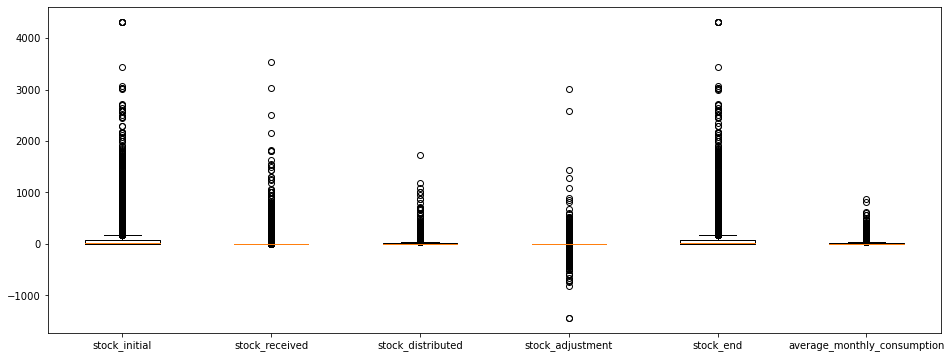

In [377]:
plt.boxplot([df["stock_initial"], df["stock_received"], df["stock_distributed"], df["stock_adjustment"], df["stock_end"], df["average_monthly_consumption"]], labels = ["stock_initial", "stock_received", "stock_distributed", "stock_adjustment", "stock_end", "average_monthly_consumption"])

# Part 2 - Exploratory Data Analysis (EDA)

## 2.1 Check unique values

The number of levels in each category:    
- site_code: 155   
- product_code (product_name): 11
- region: 20   
- district: 80   
- product type: 7   
- site_type: 3   
- site_product: 1343 (* The number of combinations of site and product should be 155*11=1705, but instead we have 1343 unique site_producct, which means that not all the combinations exist)

In [378]:
df["site_code"].unique()

array(['C1411', 'C1090', 'C1088', 'C2041', 'C4002', 'C1112', 'C2070',
       'C5063', 'C3011', 'C1413', 'C2049', 'C3021', 'C1087', 'C4014',
       'C1062', 'C2065', 'C1011', 'C2060', 'C1026', 'C1066', 'C1058',
       'C1059', 'C5003', 'C1073', 'C3019', 'C2131', 'C1029', 'C4022',
       'C1008', 'C1051', 'C2068', 'C1010', 'C2007', 'C2016', 'C2003',
       'C1098', 'C2062', 'C2011', 'C3012', 'C4019', 'C2069', 'C2051',
       'C1095', 'C4018', 'C1089', 'C4025', 'C2006', 'C2052', 'C4016',
       'C2008', 'C2053', 'C1086', 'C1024', 'C4054', 'C4015', 'C3013',
       'C1077', 'C2064', 'C4026', 'C4061', 'C2061', 'C3022', 'C3018',
       'C1069', 'C2059', 'C4001', 'C1030', 'C1093', 'C1106', 'C1082',
       'C1035', 'C1028', 'C1054', 'C2127', 'C2066', 'C1679', 'C1009',
       'C1015', 'C2047', 'C1017', 'C2056', 'C5002', 'C1070', 'C4024',
       'C1083', 'C3023', 'C1092', 'C1084', 'C2050', 'C1055', 'C2015',
       'C3043', 'C1027', 'C1034', 'C5060', 'C3020', 'C3010', 'C2055',
       'C5004', 'C40

In [379]:
len(df["site_code"].unique())

155

In [380]:
df["product_code"].unique()

array(['AS27139', 'AS17005', 'AS27132', 'AS27000', 'AS46000', 'AS27134',
       'AS27137', 'AS27133', 'AS42018', 'AS27138', 'AS21126'],
      dtype=object)

In [381]:
len(df["product_code"].unique())

11

In [382]:
df["product_name"].unique()

array(['LEVONORGESTREL 1.5 MG CP BOITE ', 'PRESERVATIF FEMININ UNITE ',
       'MICROLUT 0.03 MG BTE / 3 CYCLES BOITE ',
       'MICROGYNON 0.03/0.15 MG BTE / 3 CYCLES BOITE ',
       'PRESERVATIF MASCULIN BTE/144 BOITE ',
       'NORISTERAT 200 MG AMP INJ BTE/100 BOITE ',
       'JADELLE (IMPLANT + TROCARD) 150 µG BTE/10 BOITE ',
       'DEPO PROVERA/PETOGEN 150 MG / 3ML INJ BTE/25 BOITE ',
       'COPPER TCU 380 A (CUIVRE) UNITE ',
       'IMPLANON IMPLANT 68 MG BTE/1 BOITE ',
       'MEDROXYPROGESTERONE 104MG/0.65ML INJ UNITE (SAYANA PRESS) UNITE  '],
      dtype=object)

In [383]:
len(df["product_name"].unique())

11

In [384]:
df["region"].unique()

array(['GBOKLE-NAWA-SAN PEDRO', 'SUD-COMOE', 'ABIDJAN 1-GRANDS PONTS',
       'WORODOUGOU-BERE', 'BOUNKANI-GONTOUGO', 'AGNEBY-TIASSA-ME',
       'HAUT-SASSANDRA', 'KABADOUGOU-BAFING-FOLON', 'HAMBOL',
       "N'ZI-IFOU-MORONOU", 'PORO-TCHOLOGO-BAGOUE', 'INDENIE-DJUABLIN',
       'ABIDJAN 2', 'GOH', 'BELIER', 'LOH-DJIBOUA', 'GBEKE', 'MARAHOUE',
       'CAVALLY-GUEMON', 'TONKPI'], dtype=object)

In [385]:
len(df["region"].unique())

20

In [386]:
df["district"].unique()

array(['SOUBRE', 'GRAND-BASSAM', 'DABOU', 'SEGUELA', 'BONDOUKOU',
       'TIASSALE', 'VAVOUA', 'ODIENNE', 'DABAKALA',
       'ADJAME-PLATEAU-ATTECOUBE', 'BOCANDA', 'KORHOGO', 'AGNIBILEKROU',
       'ABOBO-EST', 'OUME', 'KOUMASSI-PORT BOUET-VRIDI', 'YOPOUGON-EST',
       'NIAKARAMADOUGOU', 'GUEYO', 'COCODY-BINGERVILLE', "M'BAHIAKRO",
       'ABOISSO', 'TIEBISSOU', 'SAN PEDRO', 'DIVO', 'DALOA', 'SIKENSI',
       'SAKASSOU', 'BOUAFLE', 'FERKESSEDOUGOU', 'DAOUKRO', 'TOUMODI',
       'DIDIEVI', 'SASSANDRA', 'BOUNA', 'FRESCO', 'PRIKRO', 'GAGNOA',
       'BONGOUANOU', 'AKOUPE', 'KATIOLA', 'YOPOUGON-OUEST-SONGON',
       'TANDA', 'ISSIA', 'LAKOTA', 'ABENGOUROU', 'ALEPE', 'ADIAKE',
       'TABOU', 'BEOUMI', 'GUIGLO', 'TENGRELA', 'JACQUEVILLE', 'ANYAMA',
       'OUANGOLO', 'BOUNDIALI', 'GUITRY', 'TOUBA', 'ADZOPE', 'BETTIE',
       'TREICHVILLE-MARCORY', 'MANKONO', 'GRAND-LAHOU', 'BIANKOUMA',
       'ZOUAN-HOUNIEN', 'BLOLEQUIN', 'DUEKOUE', 'KOUIBLY', 'TOULEPLEU',
       'DANANE', 'BANGOLO', 'ZUEN

In [387]:
len(df["district"].unique())

80

In [388]:
df["product_type"].unique()

array(['Emergency Contraceptive (Pill)', 'Female Condom',
       'Oral Contraceptive (Pill)', 'Male Condom',
       'Injectable Contraceptive', 'Contraceptive Implant',
       'Intrauterine Device (IUD)'], dtype=object)

In [389]:
len(df["product_type"].unique())

7

In [390]:
df["site_type"].unique()

array(['Health Center', 'Hospital',
       'University Hospital/National Institute'], dtype=object)

In [391]:
len(df["site_type"].unique())

3

In [392]:
len(df["site_product"].unique())

1343

There are 1054 site and product combinations in the submission file, and several of them are not present in the training data.

In [393]:
submissions["year"] = submissions["ID"].apply(lambda x: x.split()[0])
submissions["month"] = submissions["ID"].apply(lambda x: x.split()[2])
submissions["site_code"] = submissions["ID"].apply(lambda x: x.split()[4])
submissions["product_code"] = submissions["ID"].apply(lambda x: x.split()[6])
submissions["year_month"] = submissions["year"].astype(str) + submissions["month"].astype(str)
submissions["year_month"] = submissions["year_month"].apply(lambda x: datetime.datetime.strptime(x, "%Y%m"))
submissions["site_product"] = submissions["site_code"] + " X " + submissions["product_code"]
submissions = submissions.merge(product, on = "product_code")
submissions = submissions.merge(site, on = "site_code")
submissions.drop(["site_latitude", "site_longitude", "product_name"], axis = 1, inplace = True)
submissions.rename(columns={'site_region':'region', 'site_district':'district'}, inplace = True)
submissions[:5]

ID  prediction  year month site_code product_code  \
0  2019 X 7 X C4001 X AS21126           0  2019     7     C4001      AS21126   
1  2019 X 8 X C4001 X AS21126           0  2019     8     C4001      AS21126   
2  2019 X 7 X C4001 X AS27134           0  2019     7     C4001      AS27134   
3  2019 X 8 X C4001 X AS27134           0  2019     8     C4001      AS27134   
4  2019 X 9 X C4001 X AS27134           0  2019     9     C4001      AS27134   

  year_month     site_product              product_type site_type  \
0 2019-07-01  C4001 X AS21126  Injectable Contraceptive  Hospital   
1 2019-08-01  C4001 X AS21126  Injectable Contraceptive  Hospital   
2 2019-07-01  C4001 X AS27134  Injectable Contraceptive  Hospital   
3 2019-08-01  C4001 X AS27134  Injectable Contraceptive  Hospital   
4 2019-09-01  C4001 X AS27134  Injectable Contraceptive  Hospital   

             region    district  
0  INDENIE-DJUABLIN  ABENGOUROU  
1  INDENIE-DJUABLIN  ABENGOUROU  
2  INDENIE-DJUABLIN  ABENGOUROU  
3  INDENIE-DJUABLIN  ABENGOUROU  
4  INDENIE-DJUABLIN  ABENGOUROU

In [394]:
len(submissions["site_product"].unique())

1054

The following site_product combinations do not exist in the training data.

In [395]:
for i in submissions["site_product"].unique():
    if i not in df["site_product"].unique():
        print(i)

C5015 X AS27138
C5017 X AS21126
C4016 X AS21126
C3015 X AS21126
C4024 X AS27138
C3020 X AS21126
C1679 X AS27138
C1009 X AS27132
C5076 X AS27132
C5076 X AS27000
C5076 X AS27137
C5076 X AS27138
C5076 X AS27133
C5076 X AS27139


## 2.2 Check distributions

In 2019, there are no records from July to December. If we take the missing 6 months into account, the number of records in 2019 should exceed 12,000. It means that more and more data is recorded each year.

<BarContainer object of 4 artists>

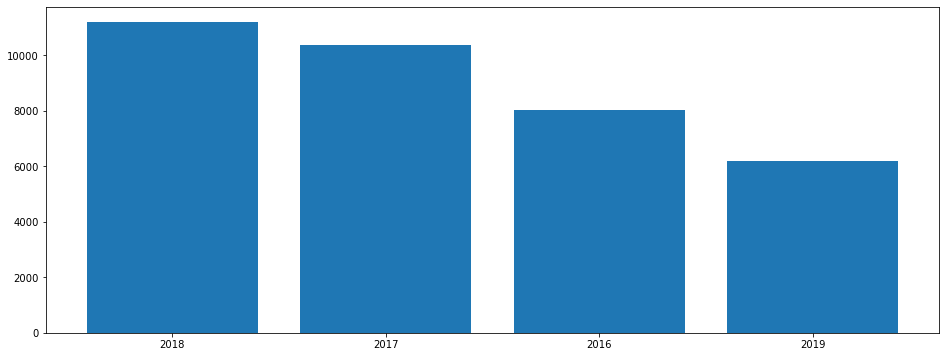

In [397]:
plt.bar(df["year"].value_counts().index, df["year"].value_counts().values)

The average number of records by each month is pretty much the same.

In [399]:
df["month"] = df["month"].astype(int)

<BarContainer object of 12 artists>

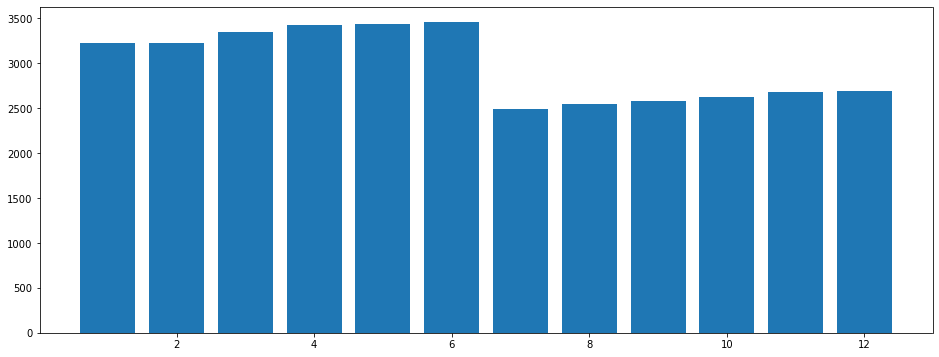

In [400]:
plt.bar(df["month"].value_counts().index, df["month"].value_counts().values)

Top 10 regions with the most number of records.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

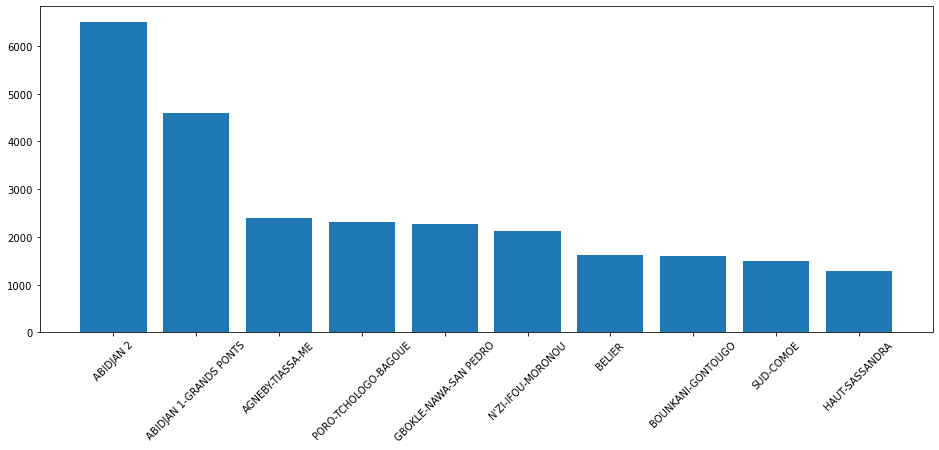

In [401]:
plt.bar(df["region"].value_counts()[:10].index, df["region"].value_counts()[:10].values)
plt.xticks(rotation = 45)

Top 10 districts with the most number of records.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

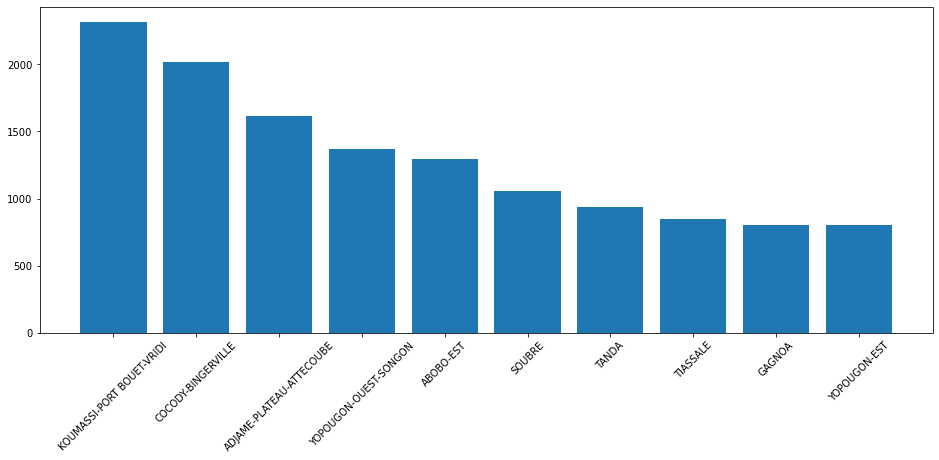

In [402]:
plt.bar(df["district"].value_counts()[:10].index, df["district"].value_counts()[:10].values)
plt.xticks(rotation = 45)

Top 10 sites with the most number of records.

<BarContainer object of 10 artists>

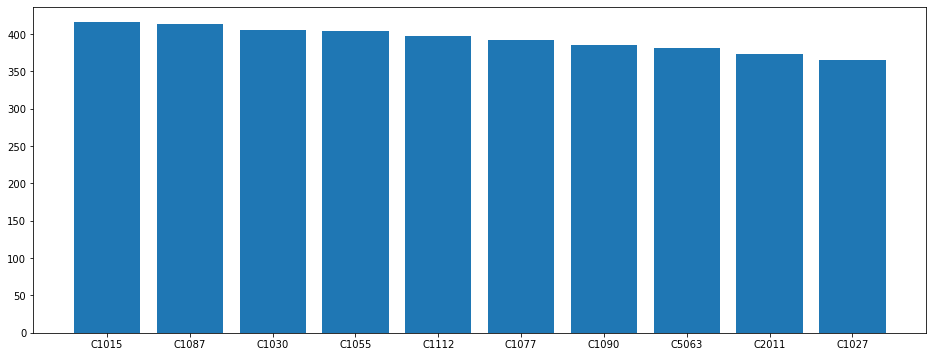

In [403]:
plt.bar(df["site_code"].value_counts()[:10].index, df["site_code"].value_counts()[:10].values)

Top 11 products with the most number of records.

<BarContainer object of 11 artists>

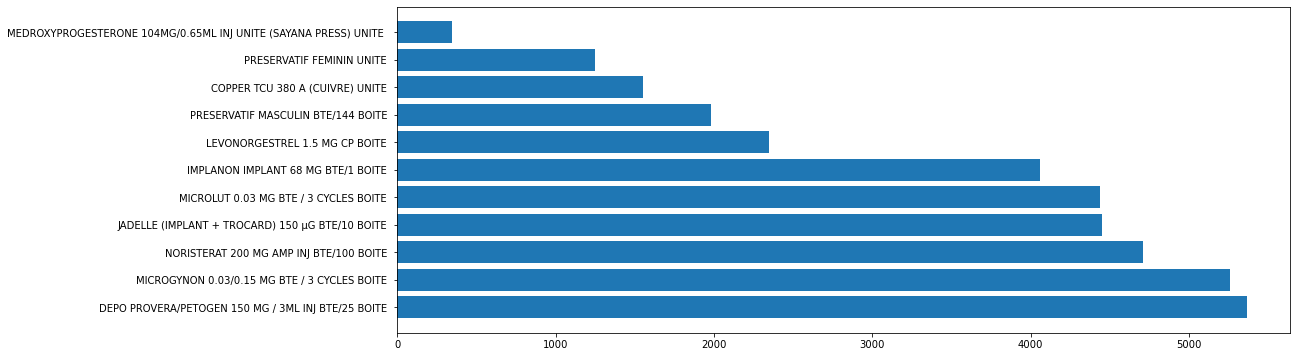

In [404]:
plt.barh(df["product_name"].value_counts().index, df["product_code"].value_counts().values)

Top 7 product types with the most number of records.

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

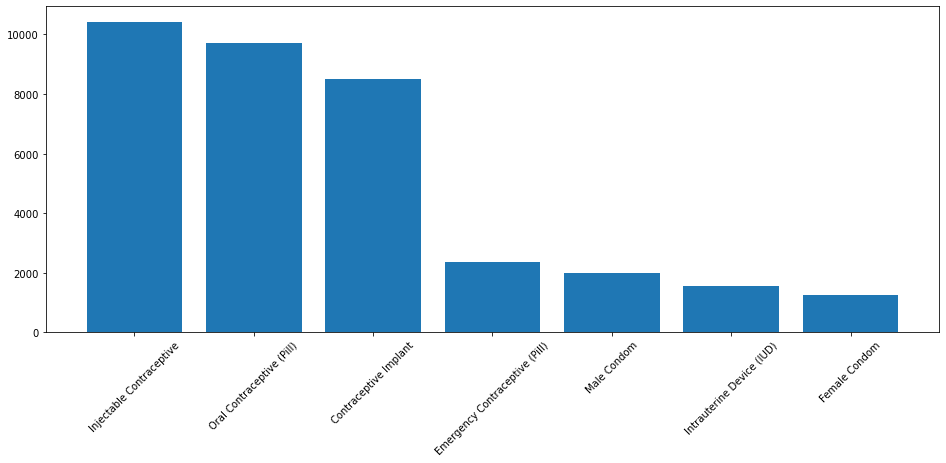

In [405]:
plt.bar(df["product_type"].value_counts().index, df["product_type"].value_counts().values)
plt.xticks(rotation = 45)

Top 3 site types with the most number of records.

<BarContainer object of 3 artists>

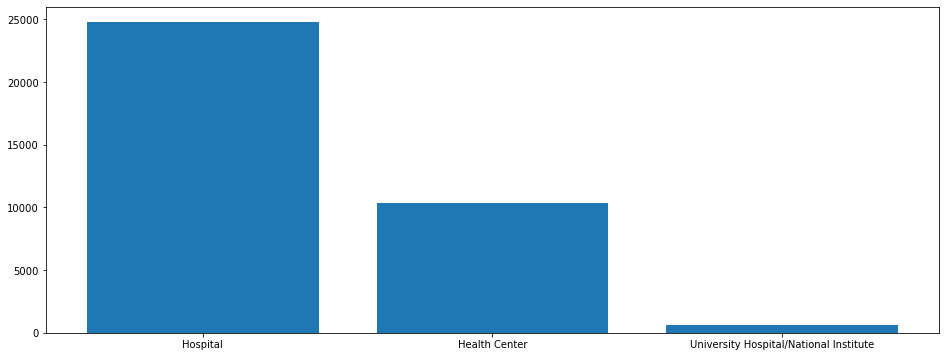

In [406]:
plt.bar(df["site_type"].value_counts().index, df["site_type"].value_counts().values)

### The distributions for columns with quantitative values are all right skewed.
I will only draw the histogram of "stock_distributed" column below.

(array([3.4359e+04, 1.0040e+03, 2.3900e+02, 9.3000e+01, 3.1000e+01,
        8.0000e+00, 2.0000e+00, 5.0000e+00, 3.0000e+00, 1.0000e+00,
        2.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   0. ,   86.4,  172.8,  259.2,  345.6,  432. ,  518.4,  604.8,
         691.2,  777.6,  864. ,  950.4, 1036.8, 1123.2, 1209.6, 1296. ,
        1382.4, 1468.8, 1555.2, 1641.6, 1728. ]),
 <BarContainer object of 20 artists>)

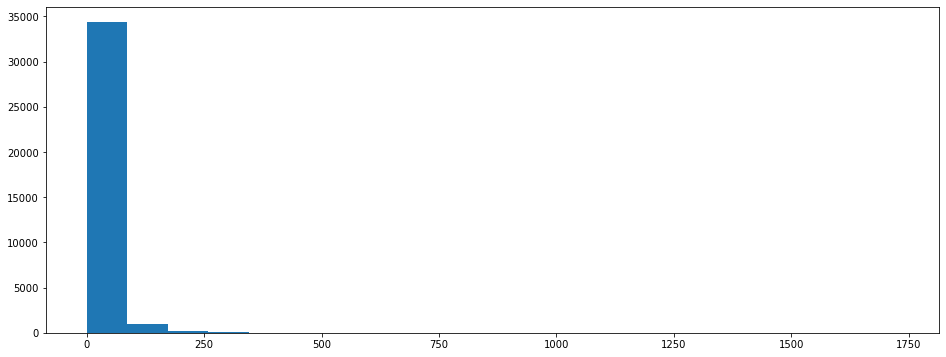

In [407]:
plt.hist(df["stock_distributed"], bins = 20)

In [487]:
#sns.distplot(df["stock_distributed"])

In [495]:
df[df["stock_distributed"]>=180].site_product.nunique()

96

## 2.3 Check relationship between a single independant variable and dependant variable

"year" & "stock_distributed":   
We cannot extract much information from "year" alone.

In [477]:
#sns.boxplot(x="year", y="stock_distributed", data=df)

<BarContainer object of 4 artists>

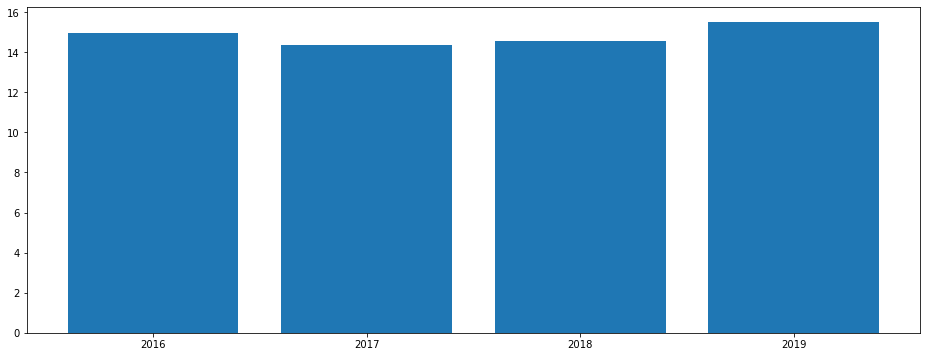

In [408]:
plt.bar(df.groupby("year")["stock_distributed"].mean().index, df.groupby("year")["stock_distributed"].mean().values)

"month" & "stock_distributed":   
We cannot extract much information from "month" alone.

<BarContainer object of 12 artists>

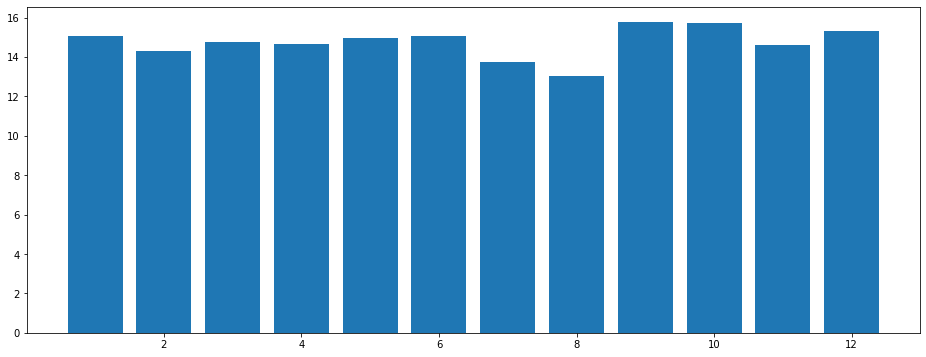

In [409]:
plt.bar(df.groupby("month")["stock_distributed"].mean().index, df.groupby("month")["stock_distributed"].mean().values)

"region" & "stock_distributed":   
"region" is a useful feature.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

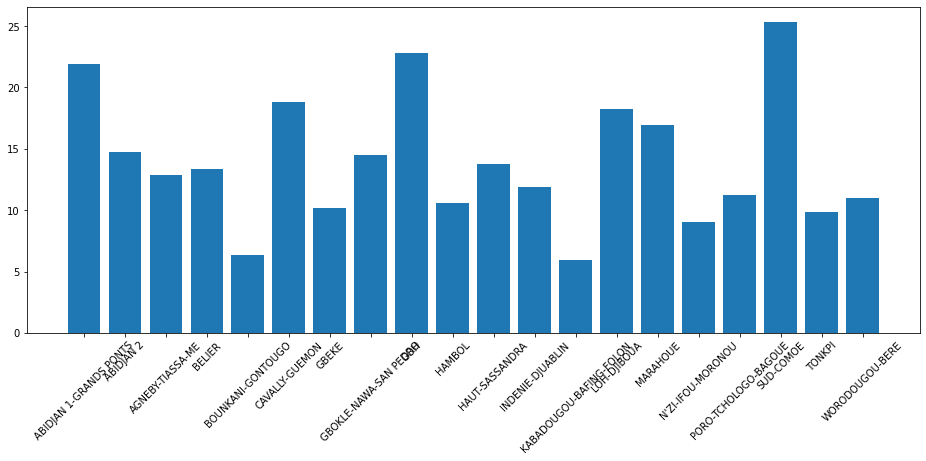

In [410]:
plt.bar(df.groupby("region")["stock_distributed"].mean().index, df.groupby("region")["stock_distributed"].mean().values)
plt.xticks(rotation = 45)

"district" & "stock_distributed":   
"district" is a useful feature.

<BarContainer object of 80 artists>

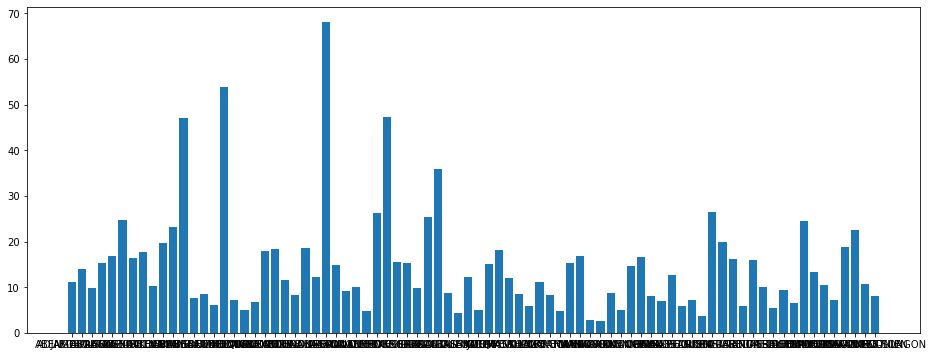

In [411]:
plt.bar(df.groupby("district")["stock_distributed"].mean().index, df.groupby("district")["stock_distributed"].mean().values)

"site_code" & "stock_distributed":   
"site_code" is a useful feature.

<BarContainer object of 155 artists>

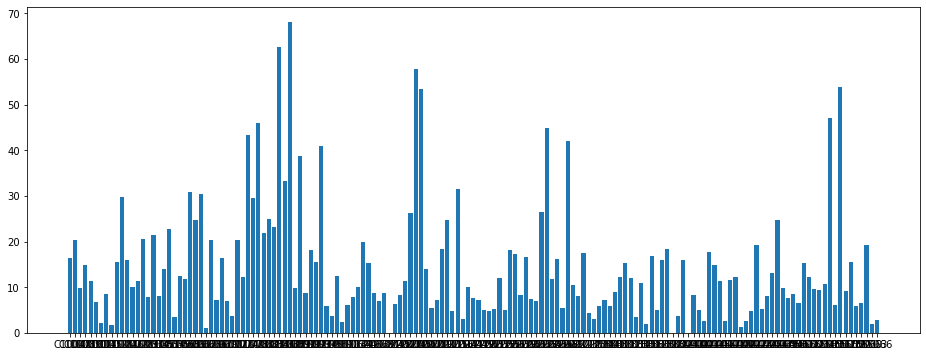

In [412]:
plt.bar(df.groupby("site_code")["stock_distributed"].mean().index, df.groupby("site_code")["stock_distributed"].mean().values)

"product_code" & "stock_distributed":   
"product_code" is a useful feature.

<BarContainer object of 11 artists>

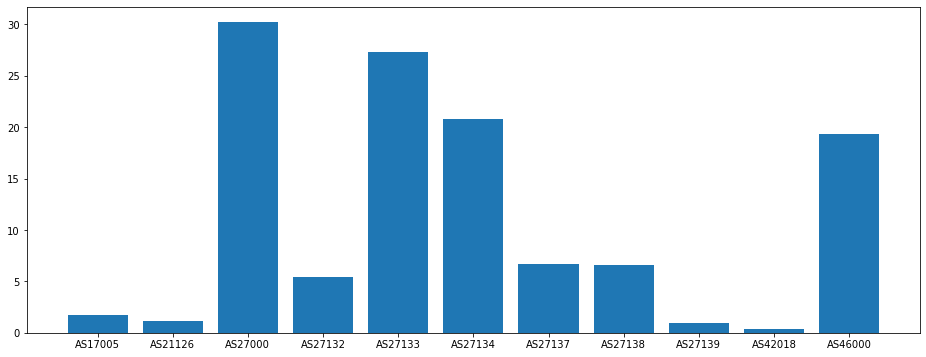

In [413]:
plt.bar(df.groupby("product_code")["stock_distributed"].mean().index, df.groupby("product_code")["stock_distributed"].mean().values)

"site_type" & "stock_distributed":   
We cannot extract much information from "site_type" alone.

<BarContainer object of 3 artists>

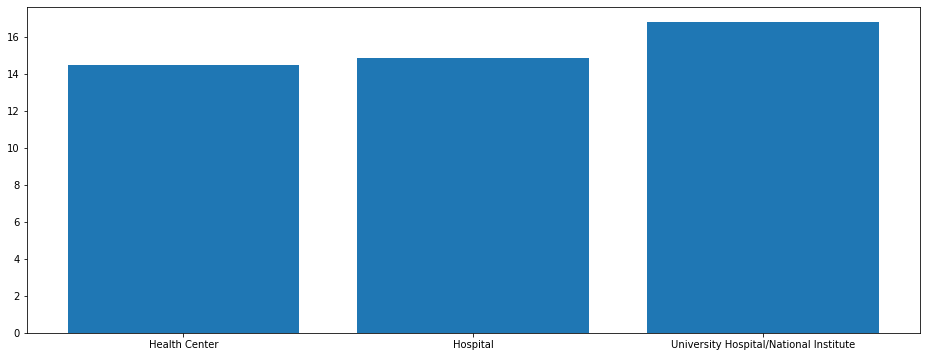

In [414]:
plt.bar(df.groupby("site_type")["stock_distributed"].mean().index, df.groupby("site_type")["stock_distributed"].mean().values)

"product_type" & "stock_distributed":   
"product_type" is a useful feature.

<BarContainer object of 7 artists>

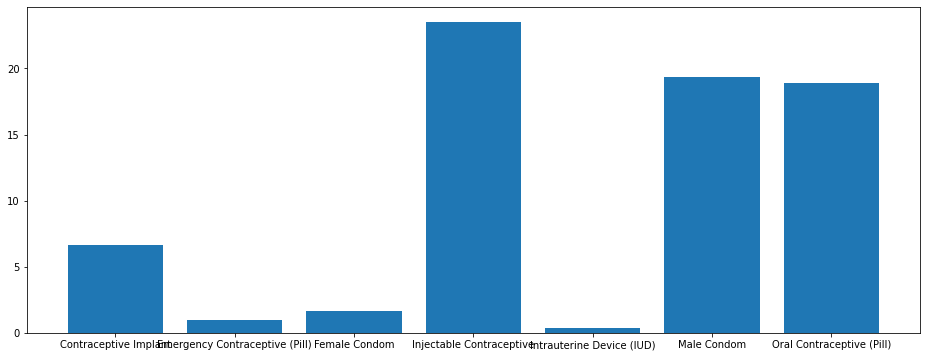

In [415]:
plt.bar(df.groupby("product_type")["stock_distributed"].mean().index, df.groupby("product_type")["stock_distributed"].mean().values)

- "average_monthly_consumption" & "site_distributed" are strongly linear postive related.  
- "stock_initial" & "site_distributed" have relative strong linear postive relationship.

In [416]:
df.corr(method = "pearson")

month  stock_initial  stock_received  \
month                        1.000000       0.004930        0.022815   
stock_initial                0.004930       1.000000        0.049173   
stock_received               0.022815       0.049173        1.000000   
stock_distributed            0.002826       0.418962        0.295552   
stock_adjustment            -0.020279      -0.075545       -0.008208   
stock_end                    0.009143       0.893060        0.391208   
average_monthly_consumption -0.000352       0.422146        0.351547   
stock_stockout_days               NaN            NaN             NaN   
stock_ordered               -0.007127       0.023768        0.042176   
site_latitude                0.003981      -0.052409       -0.051371   
site_longitude              -0.007310      -0.024169        0.014801   

                             stock_distributed  stock_adjustment  stock_end  \
month                                 0.002826         -0.020279   0.009143   
stock_initial                         0.418962         -0.075545   0.893060   
stock_received                        0.295552         -0.008208   0.391208   
stock_distributed                     1.000000          0.045175   0.312565   
stock_adjustment                      0.045175          1.000000   0.133227   
stock_end                             0.312565          0.133227   1.000000   
average_monthly_consumption           0.810097          0.037556   0.381461   
stock_stockout_days                        NaN               NaN        NaN   
stock_ordered                         0.217472          0.001467  -0.009541   
site_latitude                        -0.081957          0.000616  -0.053723   
site_longitude                        0.019200         -0.005886  -0.023524   

                             average_monthly_consumption  stock_stockout_days  \
month                                          -0.000352                  NaN   
stock_initial                                   0.422146                  NaN   
stock_received                                  0.351547                  NaN   
stock_distributed                               0.810097                  NaN   
stock_adjustment                                0.037556                  NaN   
stock_end                                       0.381461                  NaN   
average_monthly_consumption                     1.000000                  NaN   
stock_stockout_days                                  NaN                  NaN   
stock_ordered                                   0.262524                  NaN   
site_latitude                                  -0.099612                  NaN   
site_longitude                                  0.022887                  NaN   

                             stock_ordered  site_latitude  site_longitude  
month                            -0.007127       0.003981       -0.007310  
stock_initial                     0.023768      -0.052409       -0.024169  
stock_received                    0.042176      -0.051371        0.014801  
stock_distributed                 0.217472      -0.081957        0.019200  
stock_adjustment                  0.001467       0.000616       -0.005886  
stock_end                        -0.009541      -0.053723       -0.023524  
average_monthly_consumption       0.262524      -0.099612        0.022887  
stock_stockout_days                    NaN            NaN             NaN  
stock_ordered                     1.000000      -0.036881        0.000865  
site_latitude                    -0.036881       1.000000       -0.376556  
site_longitude                    0.000865      -0.376556        1.000000

In [417]:
df.corr(method = "spearman")

month  stock_initial  stock_received  \
month                        1.000000       0.037872        0.028617   
stock_initial                0.037872       1.000000       -0.041765   
stock_received               0.028617      -0.041765        1.000000   
stock_distributed            0.013515       0.586054        0.281859   
stock_adjustment            -0.023236      -0.083010       -0.001095   
stock_end                    0.036475       0.808222        0.299523   
average_monthly_consumption  0.008190       0.579246        0.294335   
stock_stockout_days               NaN            NaN             NaN   
stock_ordered               -0.031646      -0.102536        0.056644   
site_latitude                0.004822      -0.017490       -0.035015   
site_longitude              -0.004775      -0.022726        0.010178   

                             stock_distributed  stock_adjustment  stock_end  \
month                                 0.013515         -0.023236   0.036475   
stock_initial                         0.586054         -0.083010   0.808222   
stock_received                        0.281859         -0.001095   0.299523   
stock_distributed                     1.000000          0.056422   0.489807   
stock_adjustment                      0.056422          1.000000   0.085881   
stock_end                             0.489807          0.085881   1.000000   
average_monthly_consumption           0.808670          0.052087   0.526801   
stock_stockout_days                        NaN               NaN        NaN   
stock_ordered                         0.247666         -0.006188  -0.234821   
site_latitude                        -0.058624          0.010320  -0.018953   
site_longitude                       -0.000659         -0.012469  -0.020864   

                             average_monthly_consumption  stock_stockout_days  \
month                                           0.008190                  NaN   
stock_initial                                   0.579246                  NaN   
stock_received                                  0.294335                  NaN   
stock_distributed                               0.808670                  NaN   
stock_adjustment                                0.052087                  NaN   
stock_end                                       0.526801                  NaN   
average_monthly_consumption                     1.000000                  NaN   
stock_stockout_days                                  NaN                  NaN   
stock_ordered                                   0.274261                  NaN   
site_latitude                                  -0.070902                  NaN   
site_longitude                                 -0.006512                  NaN   

                             stock_ordered  site_latitude  site_longitude  
month                            -0.031646       0.004822       -0.004775  
stock_initial                    -0.102536      -0.017490       -0.022726  
stock_received                    0.056644      -0.035015        0.010178  
stock_distributed                 0.247666      -0.058624       -0.000659  
stock_adjustment                 -0.006188       0.010320       -0.012469  
stock_end                        -0.234821      -0.018953       -0.020864  
average_monthly_consumption       0.274261      -0.070902       -0.006512  
stock_stockout_days                    NaN            NaN             NaN  
stock_ordered                     1.000000      -0.043238       -0.005942  
site_latitude                    -0.043238       1.000000       -0.399176  
site_longitude                   -0.005942      -0.399176        1.000000

## 2.4 Check relationship between independant variables

Relationships between quantitative variables:  
- "stock_intial" & "stock_end" are highly correlated.
- "stock_intial" & "average_monthly_consumption" are relatively highly correlated.

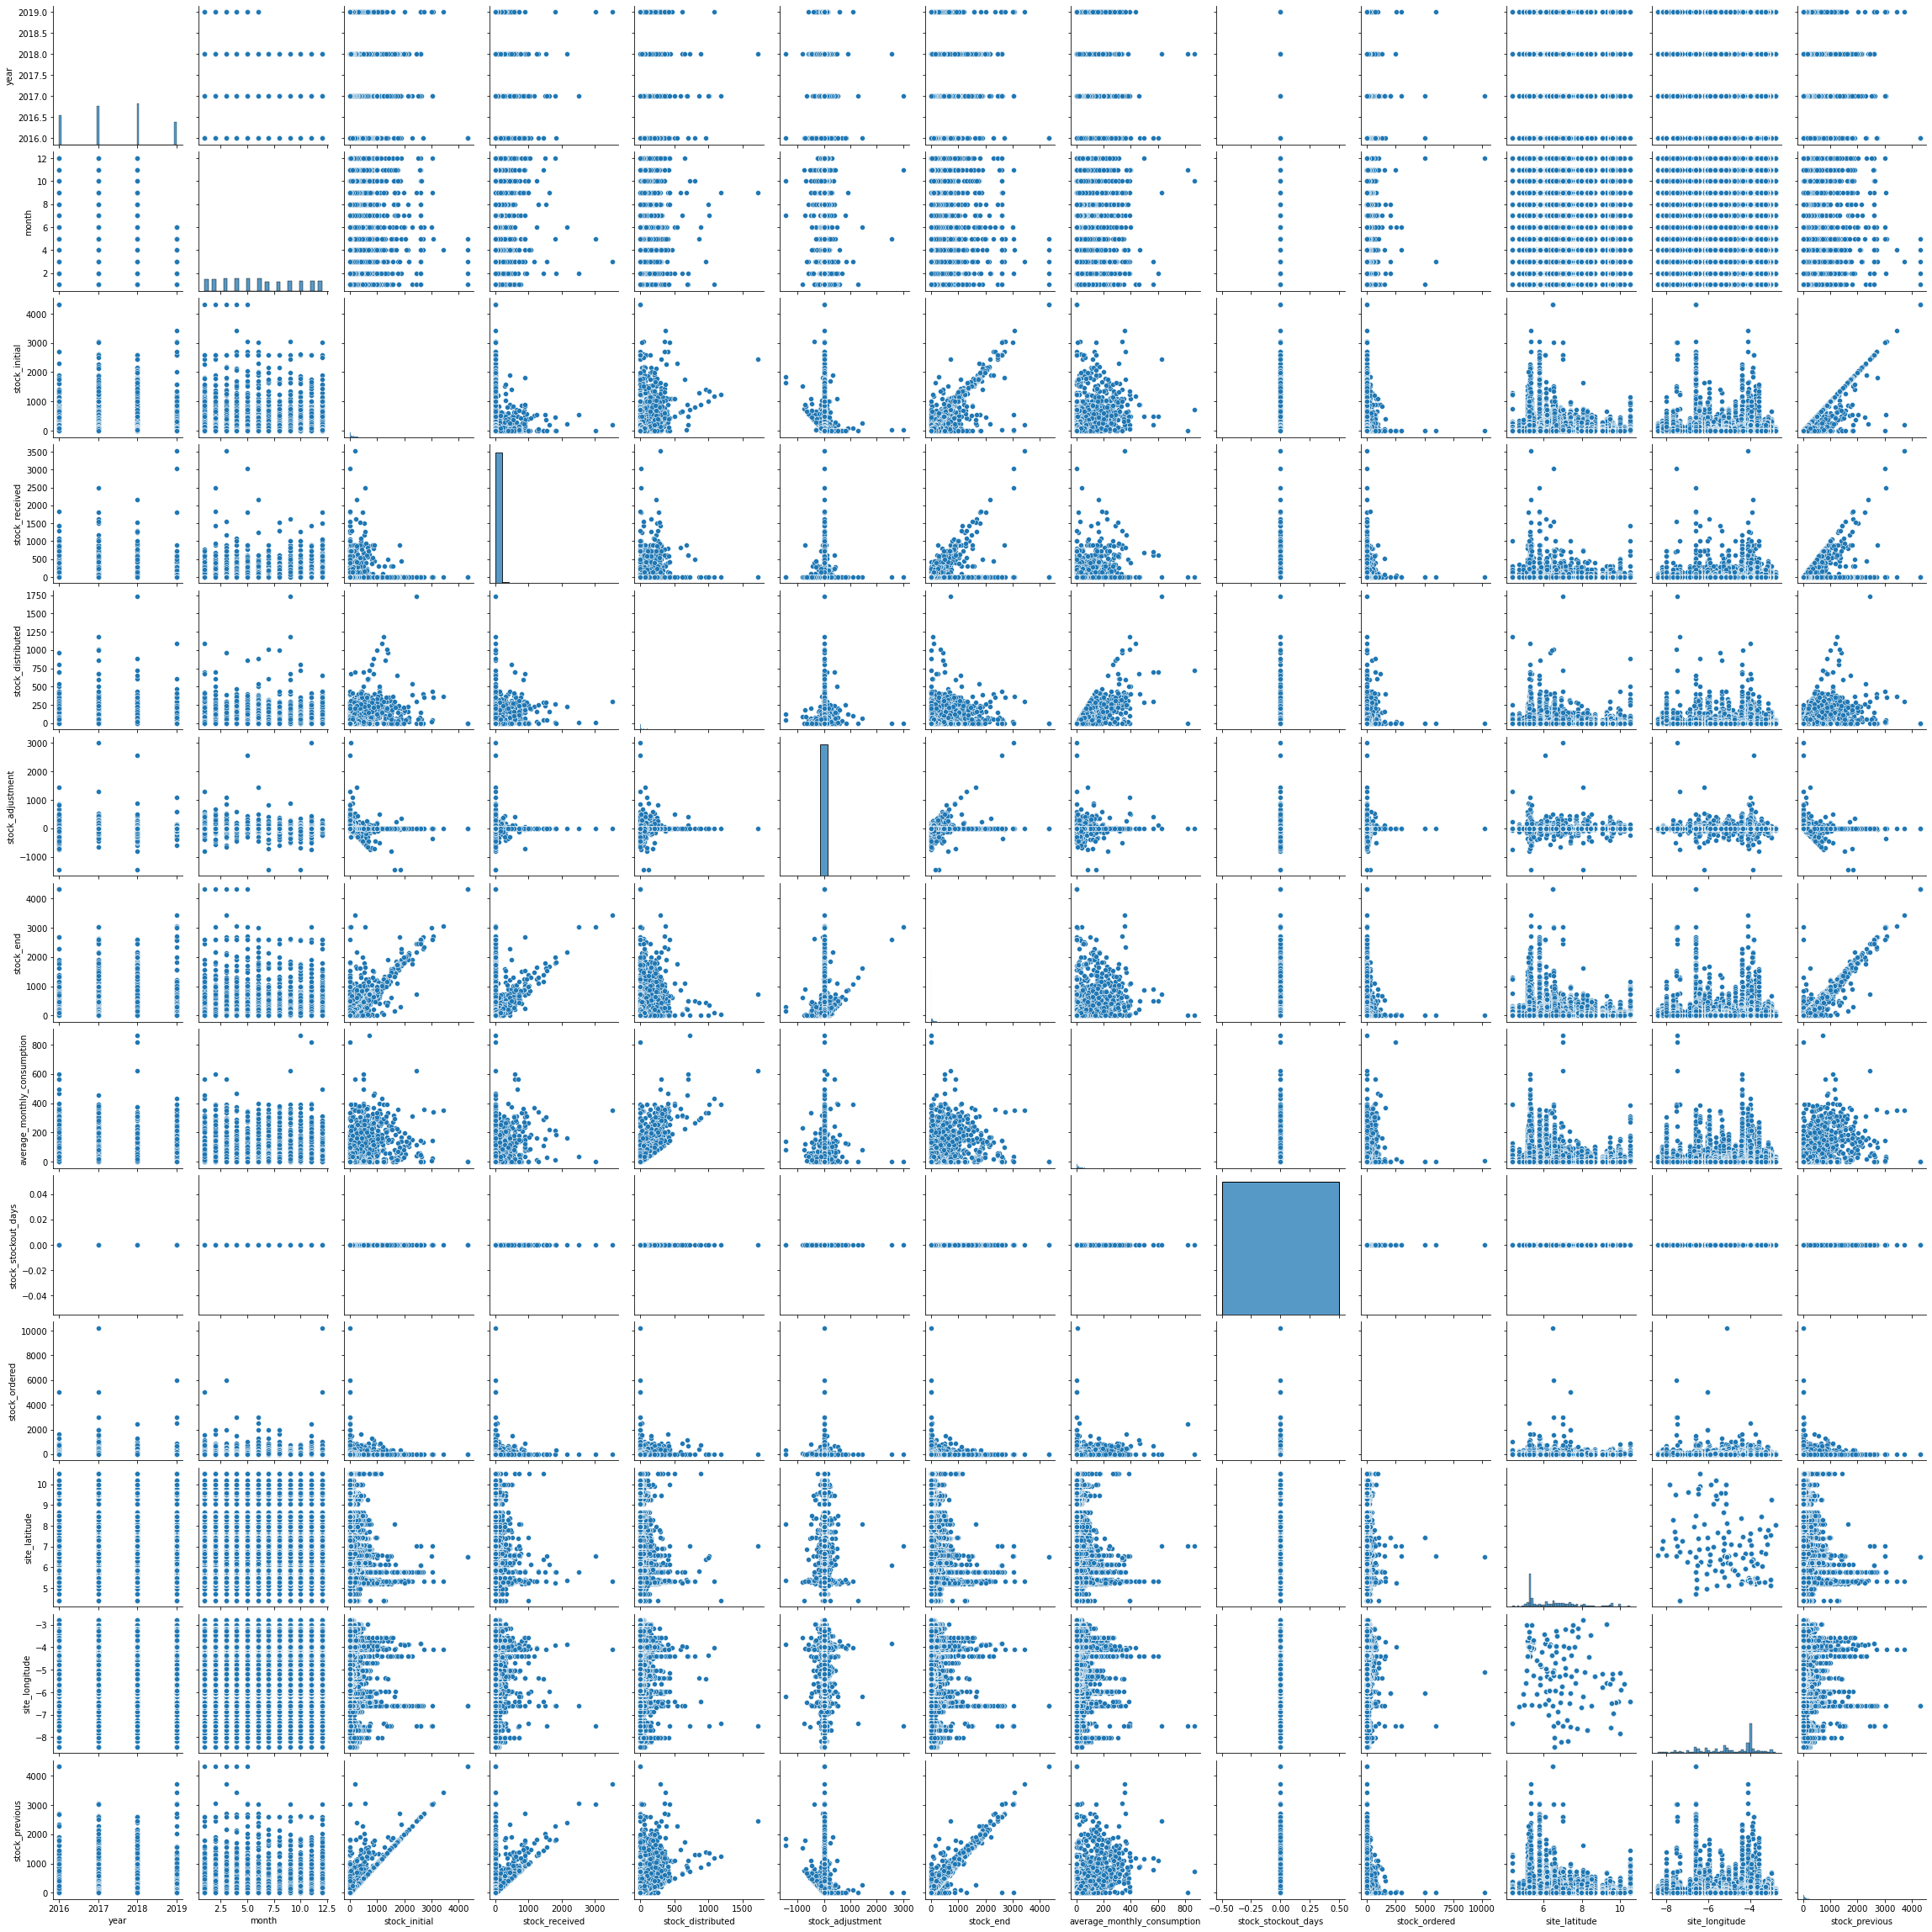

In [58]:
sns.pairplot(df)

<AxesSubplot:>

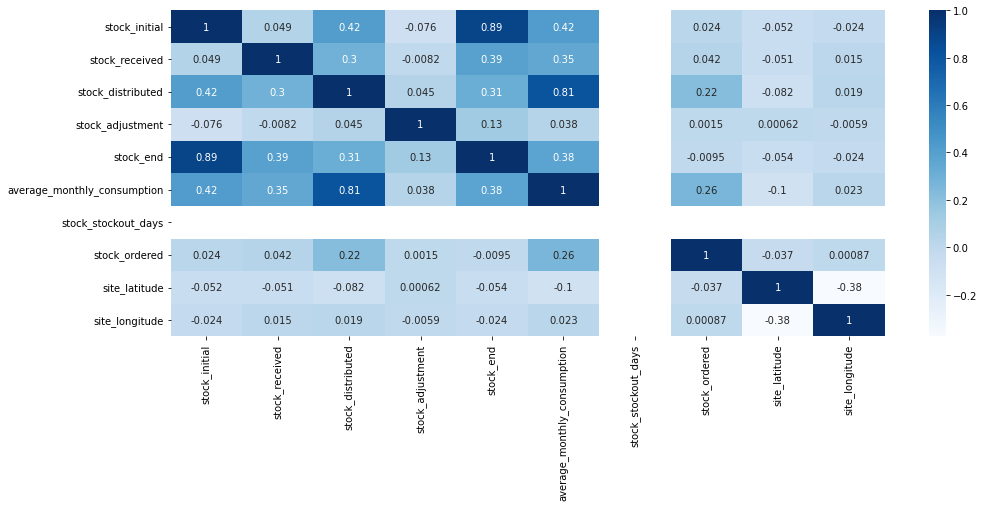

In [475]:
sns.heatmap(df.corr(method = "pearson"),cbar=True,annot=True,cmap='Blues')

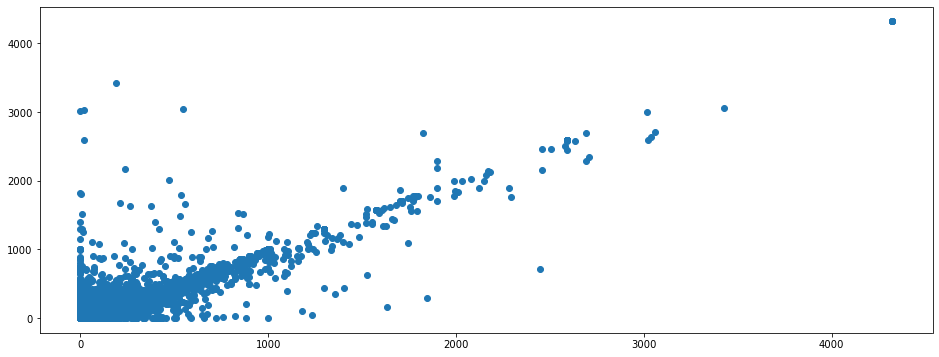

In [419]:
plt.plot(df["stock_initial"], df["stock_end"], "o")

In [420]:
df["stock_initial"].corr(df["stock_end"], method = "pearson")

0.8930600111398959

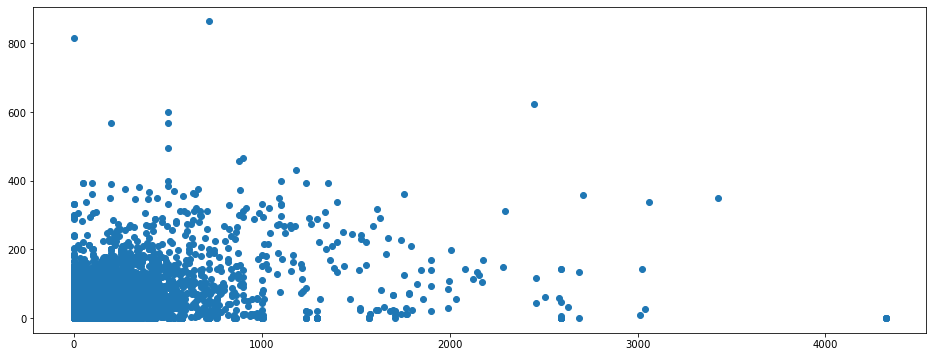

In [421]:
plt.plot(df["stock_initial"], df["average_monthly_consumption"], "o")

In [422]:
df["stock_initial"].corr(df["average_monthly_consumption"], method = "pearson")

0.42214641625447097

## 2.5 Check relationship between multiple independant variables and independant variable

"year" and "month" & "stock_distributed":   
"year" and "month" together is a useful feature.

Text(0.5, 1.0, 'Average Contraspectives Consumption by Month (2016 - 2019)')

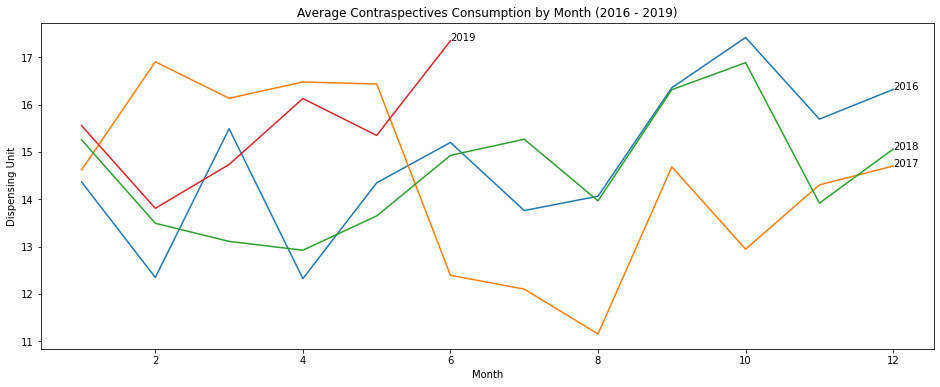

In [423]:
for i in df["year"].unique():
    df_temp = df[df["year"]==i]
    average_consumption = df_temp.groupby("month")["stock_distributed"].mean()
    plt.plot(average_consumption.index, average_consumption.values)
    plt.text(average_consumption.index[-1],average_consumption.values[-1],"{}".format(i))
plt.xlabel("Month")
plt.ylabel("Dispensing Unit")
plt.title("Average Contraspectives Consumption by Month (2016 - 2019)")

"month" and "region" & "stock_distributed":   
"month" and "region" together is a useful feature.

Text(0.5, 1.0, 'Average Contraspectives Consumption by Month (20 Regions)')

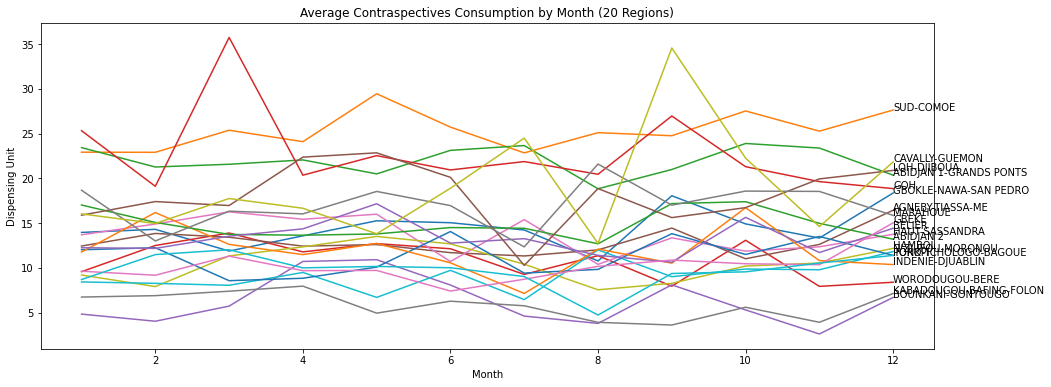

In [424]:
for i in df["region"].unique():
    df_temp = df[df["region"]==i]
    average_consumption = df_temp.groupby("month")["stock_distributed"].mean()
    plt.plot(average_consumption.index, average_consumption.values)
    plt.text(average_consumption.index[-1],average_consumption.values[-1],"{}".format(i))
plt.xlabel("Month")
plt.ylabel("Dispensing Unit")
plt.title("Average Contraspectives Consumption by Month (20 Regions)")

"district" and "month" & "stock_distributed":   
We cannot extract much information from "district" and "month" together.

Text(0.5, 1.0, 'Average Contraspectives Consumption by Month (20 Regions)')

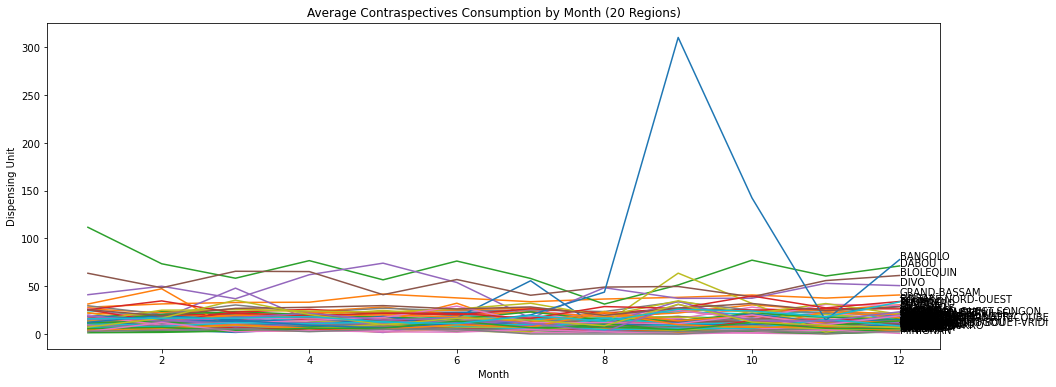

In [425]:
for i in df["district"].unique():
    df_temp = df[df["district"]==i]
    average_consumption = df_temp.groupby("month")["stock_distributed"].mean()
    plt.plot(average_consumption.index, average_consumption.values)
    plt.text(average_consumption.index[-1],average_consumption.values[-1],"{}".format(i))
plt.xlabel("Month")
plt.ylabel("Dispensing Unit")
plt.title("Average Contraspectives Consumption by Month (20 Regions)")

"site_code" and "month" & "stock_distributed":   
We cannot extract much information from "site_code" and "month" together.

Text(0.5, 1.0, 'Average Contraspectives Consumption by Month (155 Sites)')

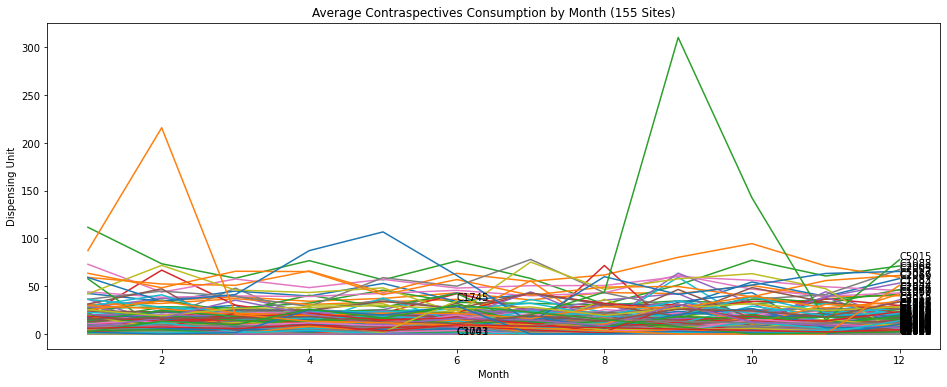

In [426]:
for i in df["site_code"].unique():
    df_temp = df[df["site_code"]==i]
    average_consumption = df_temp.groupby("month")["stock_distributed"].mean()
    plt.plot(average_consumption.index, average_consumption.values)
    plt.text(average_consumption.index[-1],average_consumption.values[-1],"{}".format(i))
plt.xlabel("Month")
plt.ylabel("Dispensing Unit")
plt.title("Average Contraspectives Consumption by Month (155 Sites)")

"product_code" and "month" & "stock_distributed":   
We cannot extract much information from "product_code" and "month" together.

Text(0.5, 1.0, 'Average Contraspectives Consumption by Month (11 Products)')

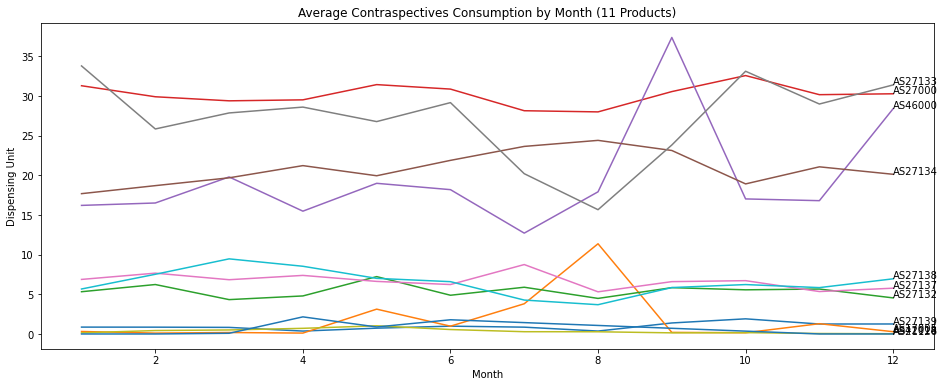

In [427]:
for i in df["product_code"].unique():
    df_temp = df[df["product_code"]==i]
    average_consumption = df_temp.groupby("month")["stock_distributed"].mean()
    plt.plot(average_consumption.index, average_consumption.values)
    plt.text(average_consumption.index[-1],average_consumption.values[-1],"{}".format(i))
plt.xlabel("Month")
plt.ylabel("Dispensing Unit")
plt.title("Average Contraspectives Consumption by Month (11 Products)")

"product_type" and "month" & "stock_distributed":   
We cannot extract much information from "product_type" and "month" together.

Text(0.5, 1.0, 'Average Contraspectives Consumption by Month (7 Product Types)')

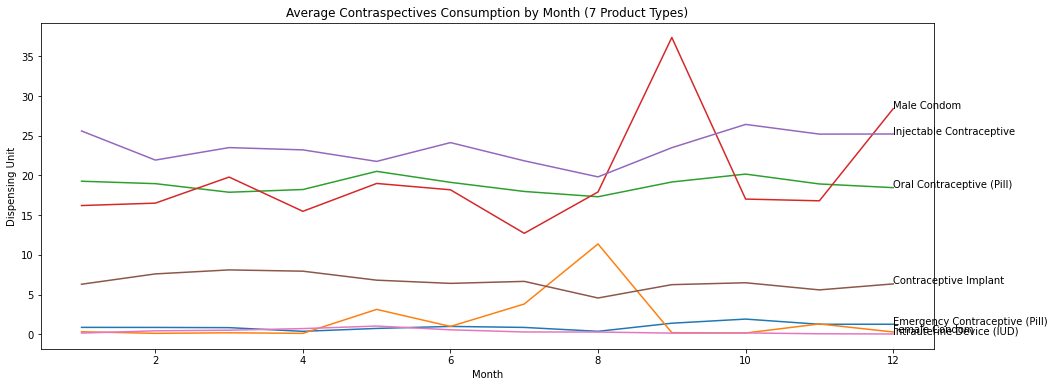

In [428]:
for i in df["product_type"].unique():
    df_temp = df[df["product_type"]==i]
    average_consumption = df_temp.groupby("month")["stock_distributed"].mean()
    plt.plot(average_consumption.index, average_consumption.values)
    plt.text(average_consumption.index[-1],average_consumption.values[-1],"{}".format(i))
plt.xlabel("Month")
plt.ylabel("Dispensing Unit")
plt.title("Average Contraspectives Consumption by Month (7 Product Types)")

"site_type" and "month" & "stock_distributed":   
We cannot extract much information from "site_type" and "month" together.

Text(0.5, 1.0, 'Average Contraspectives Consumption by Month (3 Site Types)')

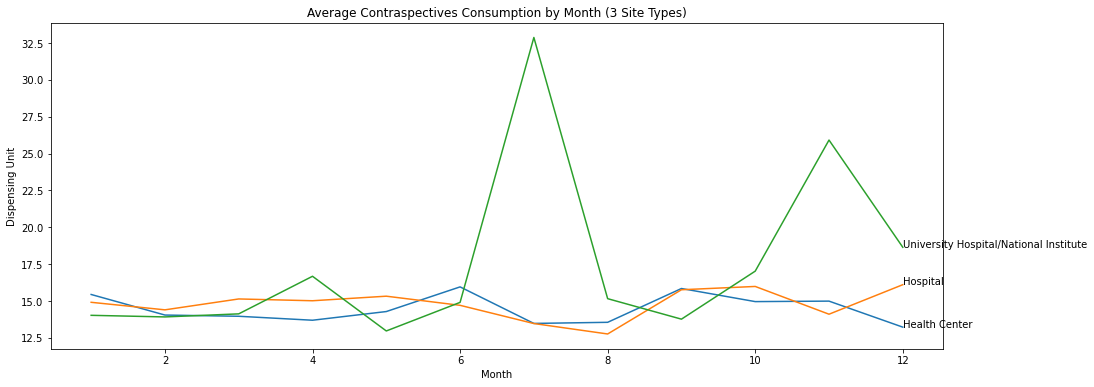

In [429]:
for i in df["site_type"].unique():
    df_temp = df[df["site_type"]==i]
    average_consumption = df_temp.groupby("month")["stock_distributed"].mean()
    plt.plot(average_consumption.index, average_consumption.values)
    plt.text(average_consumption.index[-1],average_consumption.values[-1],"{}".format(i))
plt.xlabel("Month")
plt.ylabel("Dispensing Unit")
plt.title("Average Contraspectives Consumption by Month (3 Site Types)")

"site_product" and "month" & "stock_distributed":   
"site_product" and "month" together is a useful feature.

Text(0.5, 1.0, 'Average Contraspectives Consumption by Month (1343 Site_Product)')

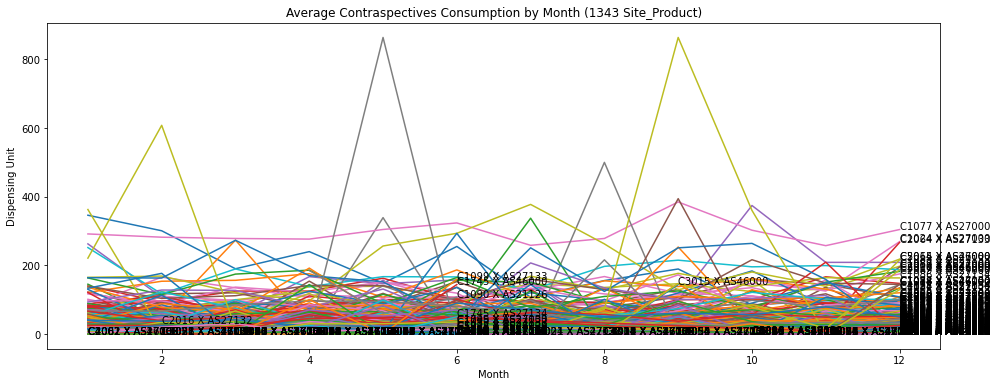

In [430]:
for i in df["site_product"].unique():
    df_temp = df[df["site_product"]==i]
    average_consumption = df_temp.groupby("month")["stock_distributed"].mean()
    plt.plot(average_consumption.index, average_consumption.values)
    plt.text(average_consumption.index[-1],average_consumption.values[-1],"{}".format(i))
plt.xlabel("Month")
plt.ylabel("Dispensing Unit")
plt.title("Average Contraspectives Consumption by Month (1343 Site_Product)")

"site_code" and "year" & "stock_distributed":   
"site_code" and "year" together is a useful feature.

Text(0.5, 1.0, 'Average Contraspectives Consumption by Year (155 Sites)')

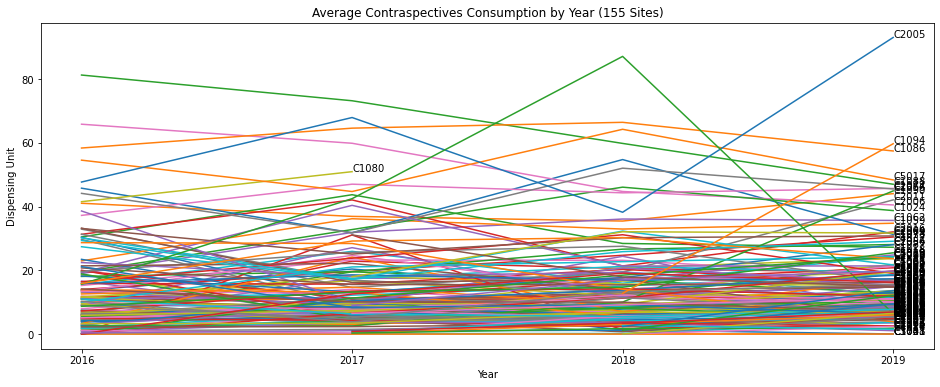

In [431]:
for i in df["site_code"].unique():
    df_temp = df[df["site_code"]==i]
    average_consumption = df_temp.groupby("year")["stock_distributed"].mean()
    plt.plot(average_consumption.index, average_consumption.values)
    plt.text(average_consumption.index[-1],average_consumption.values[-1],"{}".format(i))
plt.xlabel("Year")
plt.ylabel("Dispensing Unit")
plt.title("Average Contraspectives Consumption by Year (155 Sites)")

"product_code" and "year" & "stock_distributed":   
We cannot extract much information from "product_code" and "year" together.

Text(0.5, 1.0, 'Average Contraspectives Consumption by Year (11 Products)')

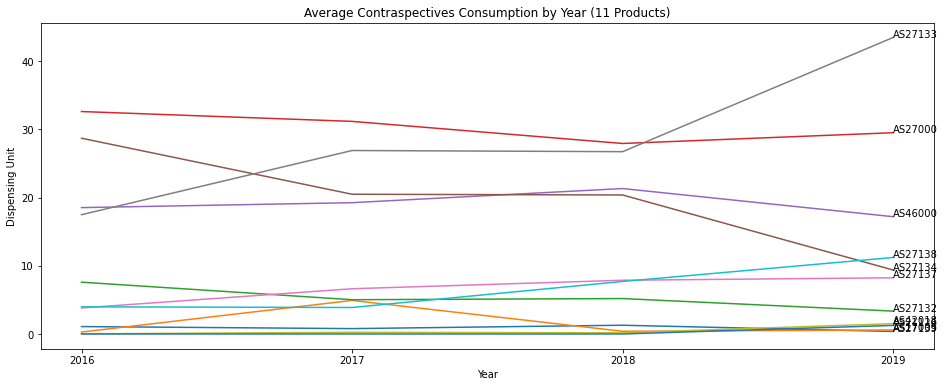

In [432]:
for i in df["product_code"].unique():
    df_temp = df[df["product_code"]==i]
    average_consumption = df_temp.groupby("year")["stock_distributed"].mean()
    plt.plot(average_consumption.index, average_consumption.values)
    plt.text(average_consumption.index[-1],average_consumption.values[-1],"{}".format(i))
plt.xlabel("Year")
plt.ylabel("Dispensing Unit")
plt.title("Average Contraspectives Consumption by Year (11 Products)")

"region" and "year" & "stock_distributed":   
"region" and "year" together is a useful feature.

Text(0.5, 1.0, 'Average Contraspectives Consumption by Year (20 Regions)')

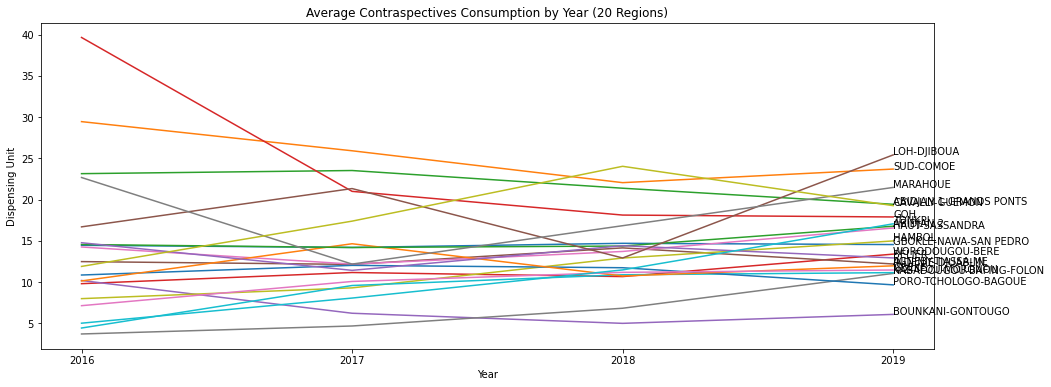

In [433]:
for i in df["region"].unique():
    df_temp = df[df["region"]==i]
    average_consumption = df_temp.groupby("year")["stock_distributed"].mean()
    plt.plot(average_consumption.index, average_consumption.values)
    plt.text(average_consumption.index[-1],average_consumption.values[-1],"{}".format(i))
plt.xlabel("Year")
plt.ylabel("Dispensing Unit")
plt.title("Average Contraspectives Consumption by Year (20 Regions)")

"district" and "year" & "stock_distributed":   
We cannot extract much information from "district" and "year" together.

Text(0.5, 1.0, 'Average Contraspectives Consumption by Year (80 Districts)')

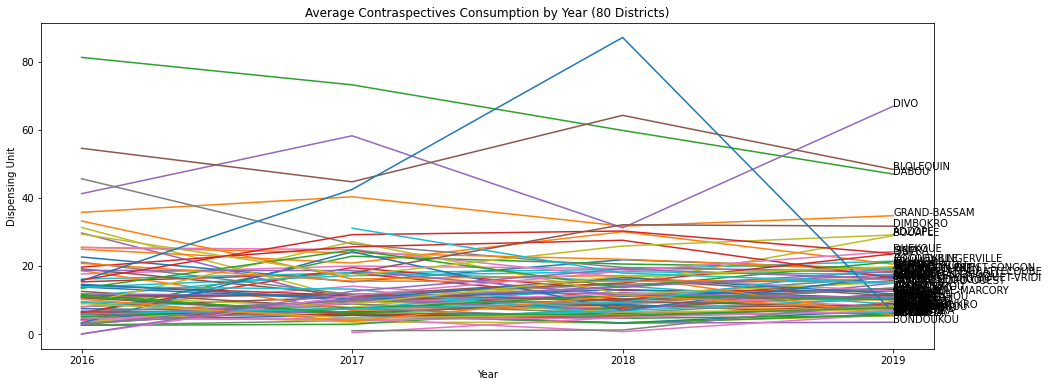

In [434]:
for i in df["district"].unique():
    df_temp = df[df["district"]==i]
    average_consumption = df_temp.groupby("year")["stock_distributed"].mean()
    plt.plot(average_consumption.index, average_consumption.values)
    plt.text(average_consumption.index[-1],average_consumption.values[-1],"{}".format(i))
plt.xlabel("Year")
plt.ylabel("Dispensing Unit")
plt.title("Average Contraspectives Consumption by Year (80 Districts)")

"site_type" and "year" & "stock_distributed":   
We cannot extract much information from "site_type" and "year" together.

Text(0.5, 1.0, 'Average Contraspectives Consumption by Year (3 Site Types)')

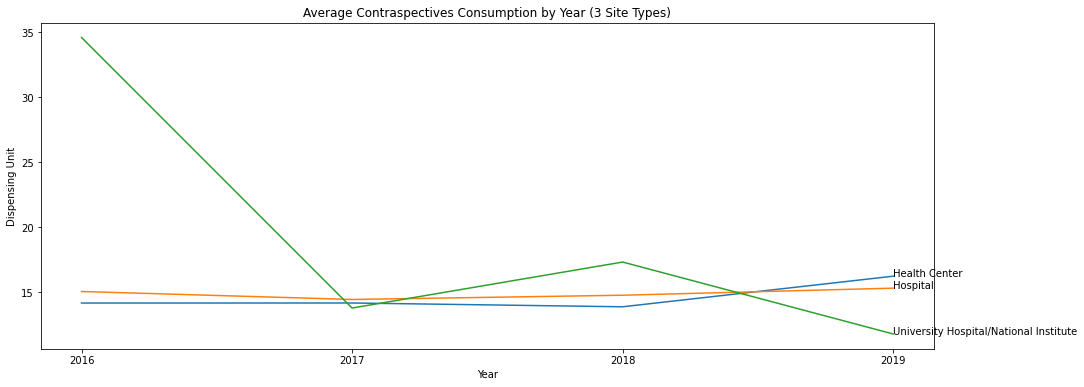

In [435]:
for i in df["site_type"].unique():
    df_temp = df[df["site_type"]==i]
    average_consumption = df_temp.groupby("year")["stock_distributed"].mean()
    plt.plot(average_consumption.index, average_consumption.values)
    plt.text(average_consumption.index[-1],average_consumption.values[-1],"{}".format(i))
plt.xlabel("Year")
plt.ylabel("Dispensing Unit")
plt.title("Average Contraspectives Consumption by Year (3 Site Types)")

"product_type" and "year" & "stock_distributed":   
We cannot extract much information from "product_type" and "year" together.

Text(0.5, 1.0, 'Average Contraspectives Consumption by Year (7 Product Types)')

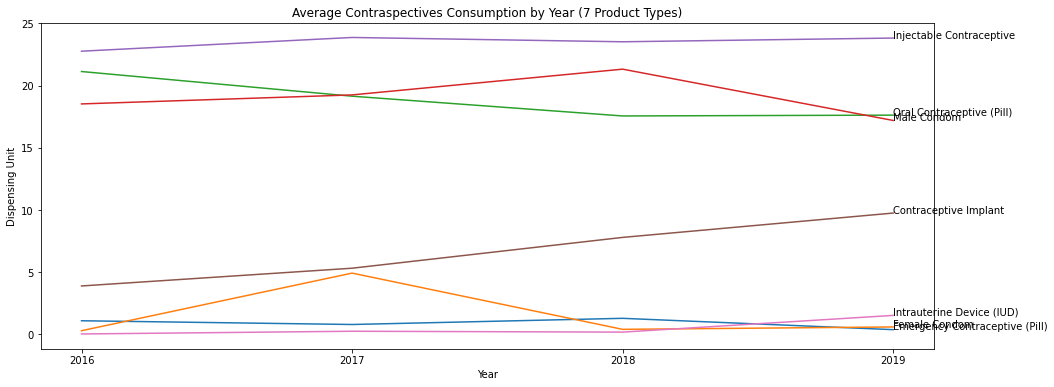

In [436]:
for i in df["product_type"].unique():
    df_temp = df[df["product_type"]==i]
    average_consumption = df_temp.groupby("year")["stock_distributed"].mean()
    plt.plot(average_consumption.index, average_consumption.values)
    plt.text(average_consumption.index[-1],average_consumption.values[-1],"{}".format(i))
plt.xlabel("Year")
plt.ylabel("Dispensing Unit")
plt.title("Average Contraspectives Consumption by Year (7 Product Types)")

"site_product" and "year" & "stock_distributed":   
"site_product" and "year" together is a useful feature.

Text(0.5, 1.0, 'Average Contraspectives Consumption by Year (1343 Site_Product)')

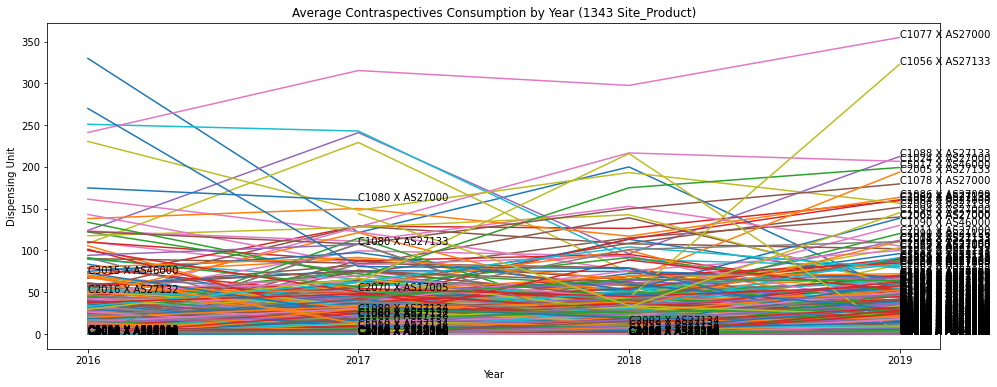

In [437]:
for i in df["site_product"].unique():
    df_temp = df[df["site_product"]==i]
    average_consumption = df_temp.groupby("year")["stock_distributed"].mean()
    plt.plot(average_consumption.index, average_consumption.values)
    plt.text(average_consumption.index[-1],average_consumption.values[-1],"{}".format(i))
plt.xlabel("Year")
plt.ylabel("Dispensing Unit")
plt.title("Average Contraspectives Consumption by Year (1343 Site_Product)")

"region" and "district" & "stock_distributed":   
"region" and "district" together is a useful feature.

Text(0.5, 1.0, 'Average Contraspectives Consumption by Region (80 Districts)')

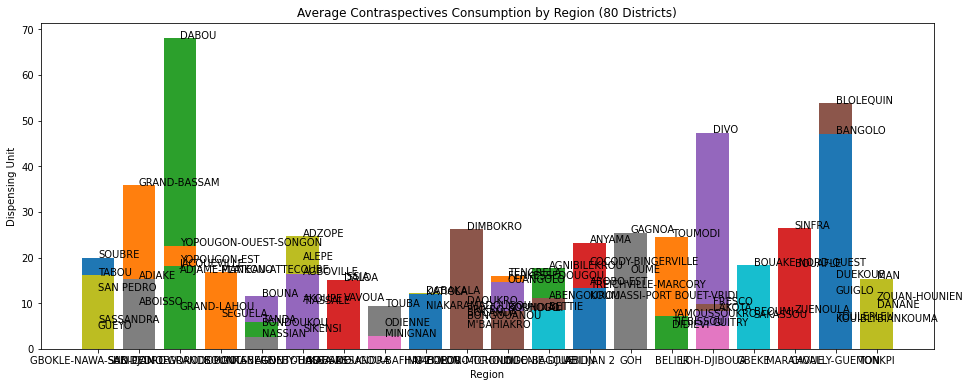

In [438]:
for i in df["district"].unique():
    df_temp = df[df["district"]==i]
    average_consumption = df_temp.groupby("region")["stock_distributed"].mean()
    plt.bar(average_consumption.index, average_consumption.values)
    plt.text(average_consumption.index[-1],average_consumption.values[-1],"{}".format(i))
plt.xlabel("Region")
plt.ylabel("Dispensing Unit")
plt.title("Average Contraspectives Consumption by Region (80 Districts)")

"region" and "site_code" & "stock_distributed":   
"region" and "site_code" together is a useful feature.

Text(0.5, 1.0, 'Average Contraspectives Consumption by Region (155 Sites)')

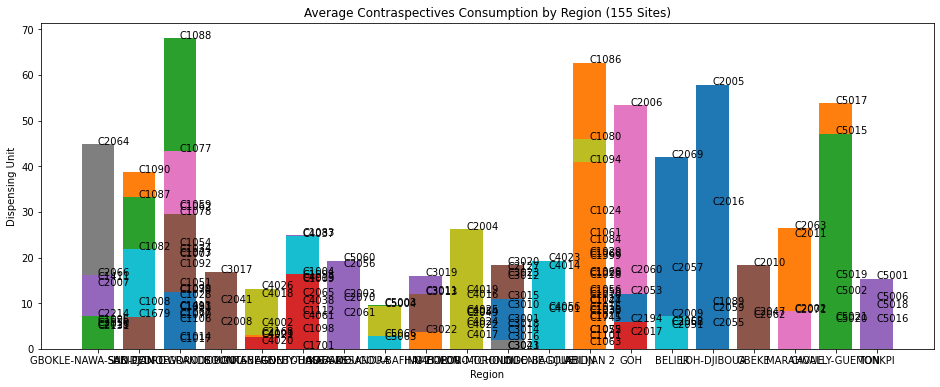

In [439]:
for i in df["site_code"].unique():
    df_temp = df[df["site_code"]==i]
    average_consumption = df_temp.groupby("region")["stock_distributed"].mean()
    plt.bar(average_consumption.index, average_consumption.values)
    plt.text(average_consumption.index[-1],average_consumption.values[-1],"{}".format(i))
plt.xlabel("Region")
plt.ylabel("Dispensing Unit")
plt.title("Average Contraspectives Consumption by Region (155 Sites)")

"region" and "product_code" & "stock_distributed":   
"region" and "product_code" together is a useful feature.

Text(0.5, 1.0, 'Average Contraspectives Consumption by Region (11 Products)')

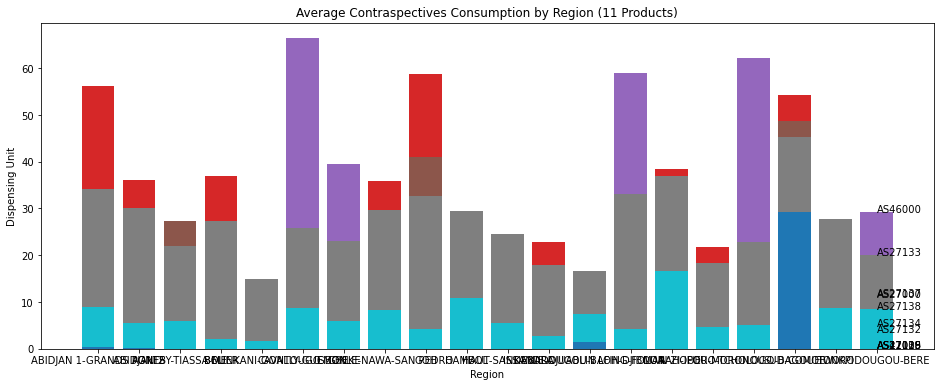

In [440]:
for i in df["product_code"].unique():
    df_temp = df[df["product_code"]==i]
    average_consumption = df_temp.groupby("region")["stock_distributed"].mean()
    plt.bar(average_consumption.index, average_consumption.values)
    plt.text(average_consumption.index[-1],average_consumption.values[-1],"{}".format(i))
plt.xlabel("Region")
plt.ylabel("Dispensing Unit")
plt.title("Average Contraspectives Consumption by Region (11 Products)")

"region" and "site_type" & "stock_distributed":   
"region" and "site_type" together is a useful feature.

Text(0.5, 1.0, 'Average Contraspectives Consumption by Region (3 Site Types)')

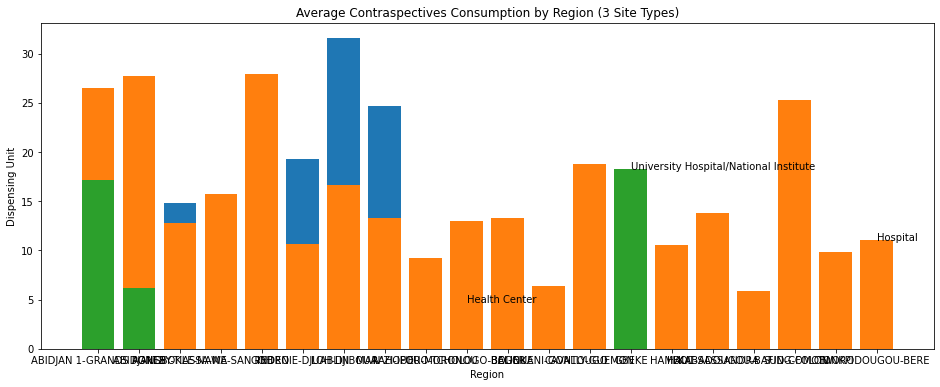

In [441]:
for i in df["site_type"].unique():
    df_temp = df[df["site_type"]==i]
    average_consumption = df_temp.groupby("region")["stock_distributed"].mean()
    plt.bar(average_consumption.index, average_consumption.values)
    plt.text(average_consumption.index[-1],average_consumption.values[-1],"{}".format(i))
plt.xlabel("Region")
plt.ylabel("Dispensing Unit")
plt.title("Average Contraspectives Consumption by Region (3 Site Types)")

"region" and "product_type" & "stock_distributed":   
"region" and "product_type" together is a useful feature.

Text(0.5, 1.0, 'Average Contraspectives Consumption by Region (7 Product Types)')

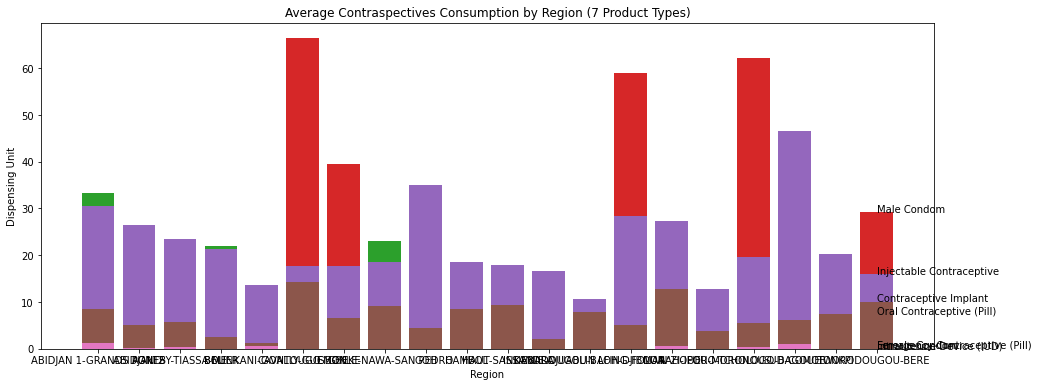

In [442]:
for i in df["product_type"].unique():
    df_temp = df[df["product_type"]==i]
    average_consumption = df_temp.groupby("region")["stock_distributed"].mean()
    plt.bar(average_consumption.index, average_consumption.values)
    plt.text(average_consumption.index[-1],average_consumption.values[-1],"{}".format(i))
plt.xlabel("Region")
plt.ylabel("Dispensing Unit")
plt.title("Average Contraspectives Consumption by Region (7 Product Types)")

"region" and "site_product" & "stock_distributed":   
"region" and "site_product" together is a useful feature.

Text(0.5, 1.0, 'Average Contraspectives Consumption by Region (1343 Site_Product)')

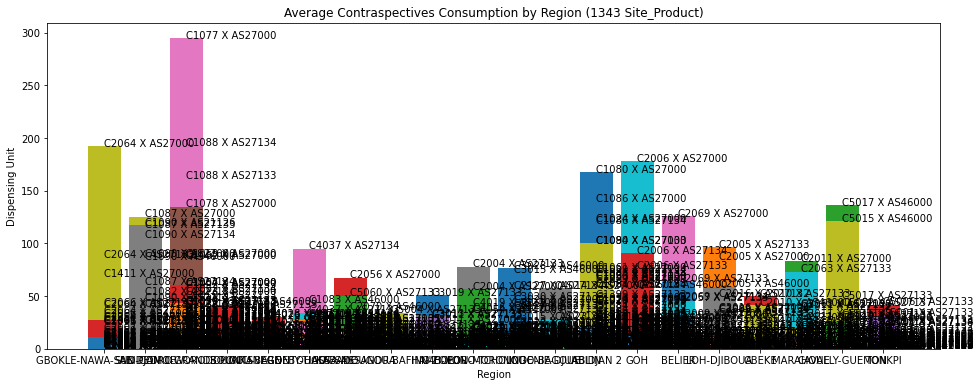

In [443]:
for i in df["site_product"].unique():
    df_temp = df[df["site_product"]==i]
    average_consumption = df_temp.groupby("region")["stock_distributed"].mean()
    plt.bar(average_consumption.index, average_consumption.values)
    plt.text(average_consumption.index[-1],average_consumption.values[-1],"{}".format(i))
plt.xlabel("Region")
plt.ylabel("Dispensing Unit")
plt.title("Average Contraspectives Consumption by Region (1343 Site_Product)")

### All the below combinations are useful features.

Text(0.5, 1.0, 'Average Contraspectives Consumption by Region (155 Sites)')

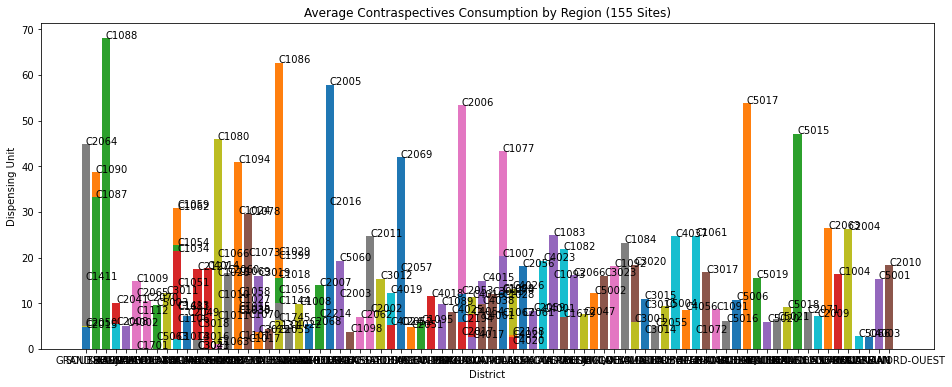

In [444]:
for i in df["site_code"].unique():
    df_temp = df[df["site_code"]==i]
    average_consumption = df_temp.groupby("district")["stock_distributed"].mean()
    plt.bar(average_consumption.index, average_consumption.values)
    plt.text(average_consumption.index[-1],average_consumption.values[-1],"{}".format(i))
plt.xlabel("District")
plt.ylabel("Dispensing Unit")
plt.title("Average Contraspectives Consumption by Region (155 Sites)")

Text(0.5, 1.0, 'Average Contraspectives Consumption by Region (11 Products)')

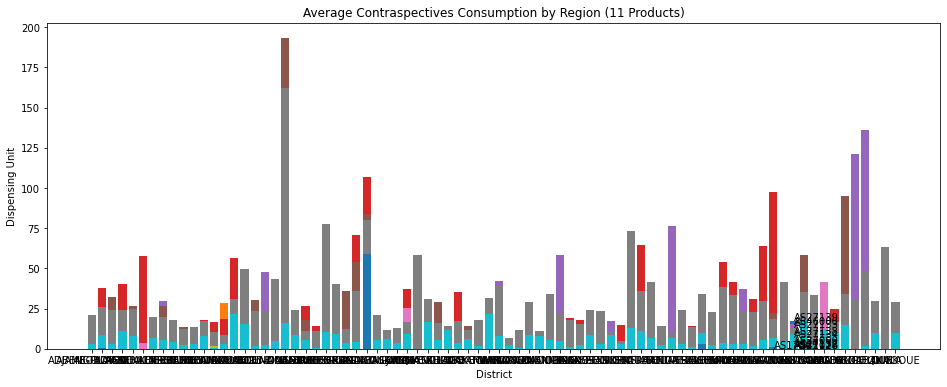

In [445]:
for i in df["product_code"].unique():
    df_temp = df[df["product_code"]==i]
    average_consumption = df_temp.groupby("district")["stock_distributed"].mean()
    plt.bar(average_consumption.index, average_consumption.values)
    plt.text(average_consumption.index[-1],average_consumption.values[-1],"{}".format(i))
plt.xlabel("District")
plt.ylabel("Dispensing Unit")
plt.title("Average Contraspectives Consumption by Region (11 Products)")

Text(0.5, 1.0, 'Average Contraspectives Consumption by Region (3 Site Types)')

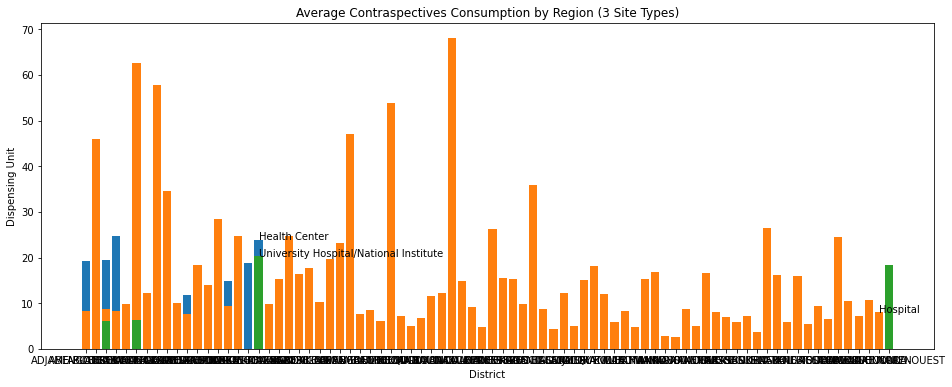

In [446]:
for i in df["site_type"].unique():
    df_temp = df[df["site_type"]==i]
    average_consumption = df_temp.groupby("district")["stock_distributed"].mean()
    plt.bar(average_consumption.index, average_consumption.values)
    plt.text(average_consumption.index[-1],average_consumption.values[-1],"{}".format(i))
plt.xlabel("District")
plt.ylabel("Dispensing Unit")
plt.title("Average Contraspectives Consumption by Region (3 Site Types)")

Text(0.5, 1.0, 'Average Contraspectives Consumption by Region (7 Product Types)')

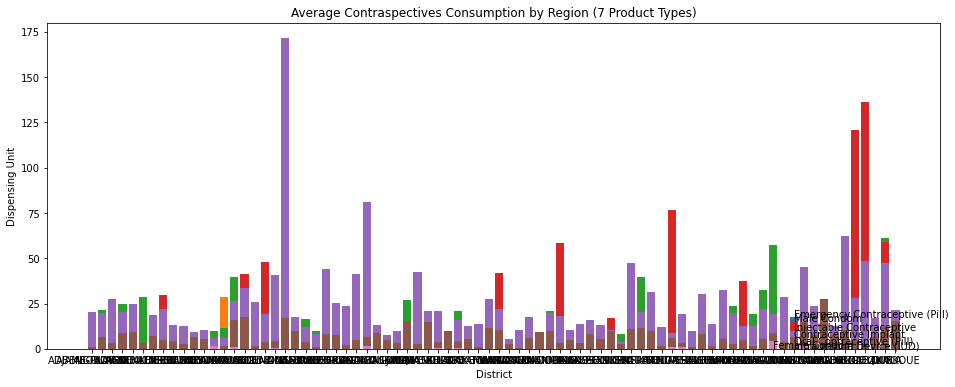

In [447]:
for i in df["product_type"].unique():
    df_temp = df[df["product_type"]==i]
    average_consumption = df_temp.groupby("district")["stock_distributed"].mean()
    plt.bar(average_consumption.index, average_consumption.values)
    plt.text(average_consumption.index[-1],average_consumption.values[-1],"{}".format(i))
plt.xlabel("District")
plt.ylabel("Dispensing Unit")
plt.title("Average Contraspectives Consumption by Region (7 Product Types)")

Text(0.5, 1.0, 'Average Contraspectives Consumption by Region (1343 Site_Product)')

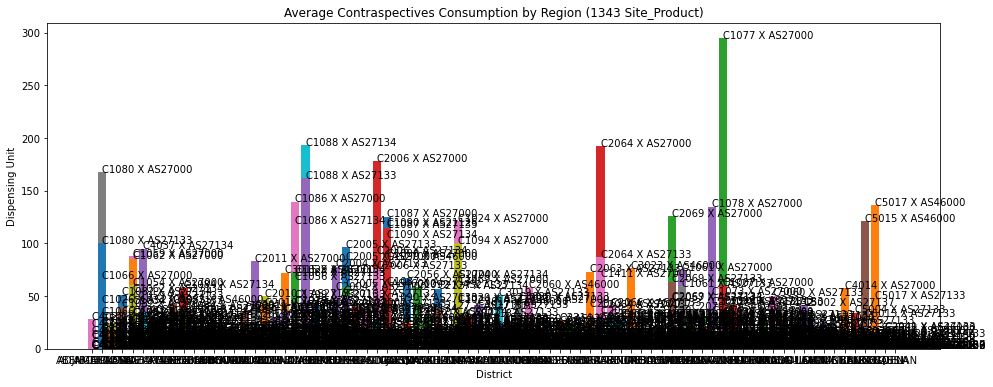

In [263]:
for i in df["site_product"].unique():
    df_temp = df[df["site_product"]==i]
    average_consumption = df_temp.groupby("district")["stock_distributed"].mean()
    plt.bar(average_consumption.index, average_consumption.values)
    plt.text(average_consumption.index[-1],average_consumption.values[-1],"{}".format(i))
plt.xlabel("District")
plt.ylabel("Dispensing Unit")
plt.title("Average Contraspectives Consumption by Region (1343 Site_Product)")

Text(0.5, 1.0, 'Average Contraspectives Consumption by Region (11 Products)')

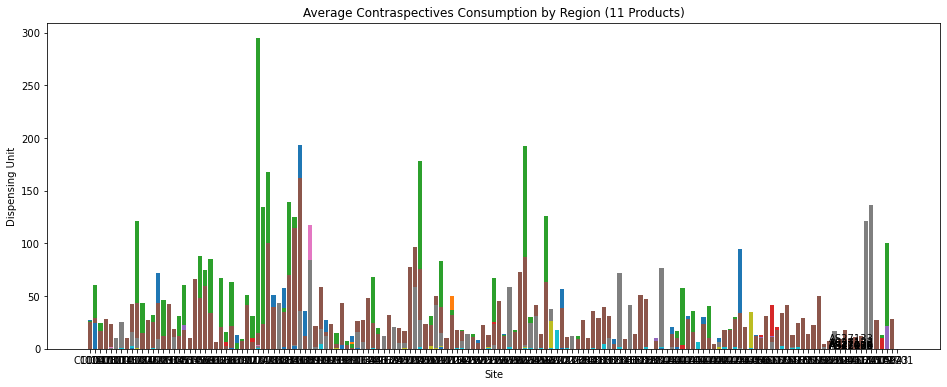

In [264]:
for i in df["product_code"].unique():
    df_temp = df[df["product_code"]==i]
    average_consumption = df_temp.groupby("site_code")["stock_distributed"].mean()
    plt.bar(average_consumption.index, average_consumption.values)
    plt.text(average_consumption.index[-1],average_consumption.values[-1],"{}".format(i))
plt.xlabel("Site")
plt.ylabel("Dispensing Unit")
plt.title("Average Contraspectives Consumption by Region (11 Products)")

Text(0.5, 1.0, 'Average Contraspectives Consumption by Region (3 Site Types)')

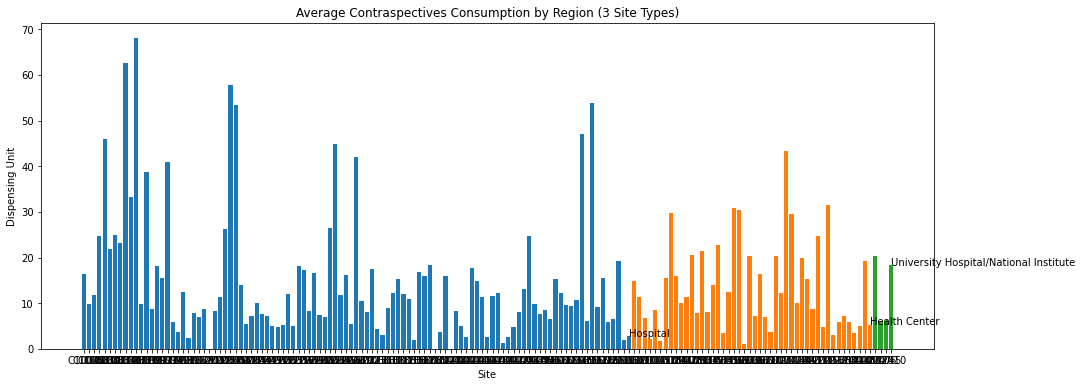

In [265]:
for i in df["site_type"].unique():
    df_temp = df[df["site_type"]==i]
    average_consumption = df_temp.groupby("site_code")["stock_distributed"].mean()
    plt.bar(average_consumption.index, average_consumption.values)
    plt.text(average_consumption.index[-1],average_consumption.values[-1],"{}".format(i))
plt.xlabel("Site")
plt.ylabel("Dispensing Unit")
plt.title("Average Contraspectives Consumption by Region (3 Site Types)")

Text(0.5, 1.0, 'Average Contraspectives Consumption by Region (7 Product Types)')

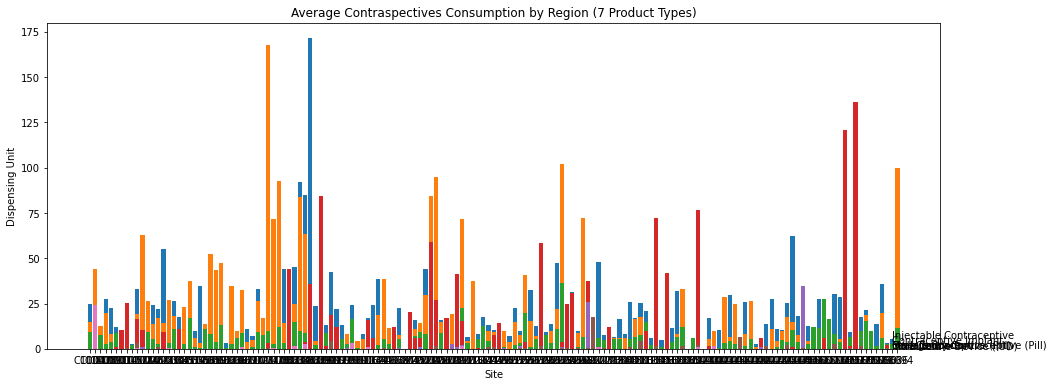

In [266]:
for i in df["product_type"].unique():
    df_temp = df[df["product_type"]==i]
    average_consumption = df_temp.groupby("site_code")["stock_distributed"].mean()
    plt.bar(average_consumption.index, average_consumption.values)
    plt.text(average_consumption.index[-1],average_consumption.values[-1],"{}".format(i))
plt.xlabel("Site")
plt.ylabel("Dispensing Unit")
plt.title("Average Contraspectives Consumption by Region (7 Product Types)")

Text(0.5, 1.0, 'Average Contraspectives Consumption by Region (1343 Site_Product)')

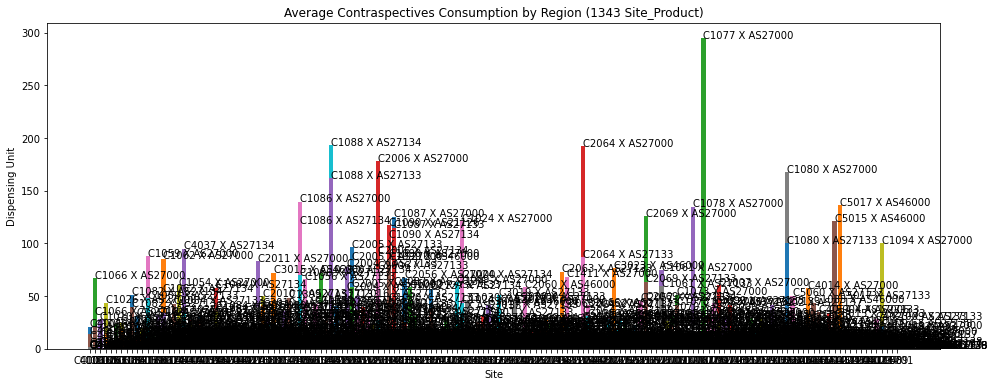

In [267]:
for i in df["site_product"].unique():
    df_temp = df[df["site_product"]==i]
    average_consumption = df_temp.groupby("site_code")["stock_distributed"].mean()
    plt.bar(average_consumption.index, average_consumption.values)
    plt.text(average_consumption.index[-1],average_consumption.values[-1],"{}".format(i))
plt.xlabel("Site")
plt.ylabel("Dispensing Unit")
plt.title("Average Contraspectives Consumption by Region (1343 Site_Product)")

Text(0.5, 1.0, 'Average Contraspectives Consumption by Region (3 Site Types)')

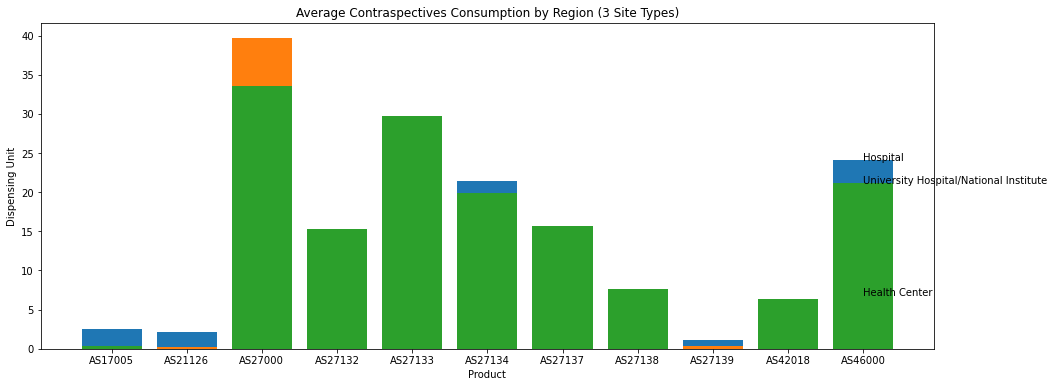

In [268]:
for i in df["site_type"].unique():
    df_temp = df[df["site_type"]==i]
    average_consumption = df_temp.groupby("product_code")["stock_distributed"].mean()
    plt.bar(average_consumption.index, average_consumption.values)
    plt.text(average_consumption.index[-1],average_consumption.values[-1],"{}".format(i))
plt.xlabel("Product")
plt.ylabel("Dispensing Unit")
plt.title("Average Contraspectives Consumption by Region (3 Site Types)")

Text(0.5, 1.0, 'Average Contraspectives Consumption by Region (7 Product Types)')

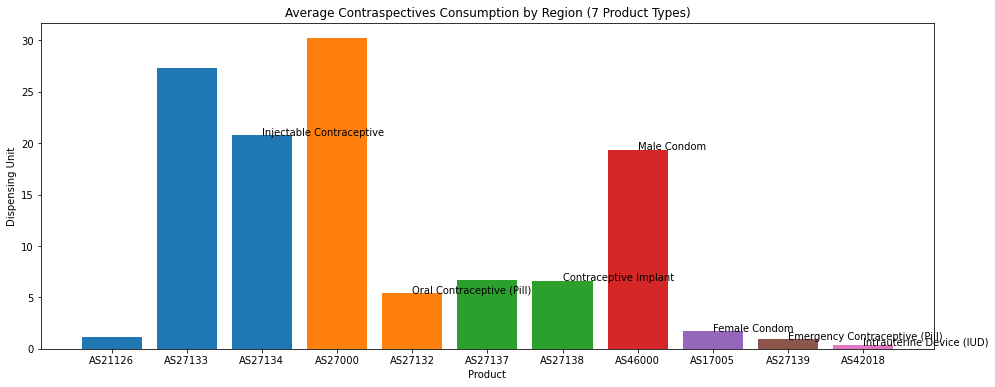

In [269]:
for i in df["product_type"].unique():
    df_temp = df[df["product_type"]==i]
    average_consumption = df_temp.groupby("product_code")["stock_distributed"].mean()
    plt.bar(average_consumption.index, average_consumption.values)
    plt.text(average_consumption.index[-1],average_consumption.values[-1],"{}".format(i))
plt.xlabel("Product")
plt.ylabel("Dispensing Unit")
plt.title("Average Contraspectives Consumption by Region (7 Product Types)")

Text(0.5, 1.0, 'Average Contraspectives Consumption by Region (1343 Site_Product)')

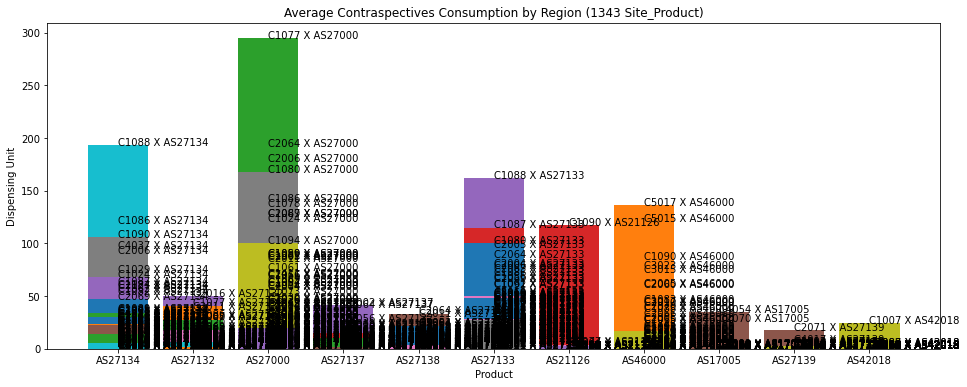

In [270]:
for i in df["site_product"].unique():
    df_temp = df[df["site_product"]==i]
    average_consumption = df_temp.groupby("product_code")["stock_distributed"].mean()
    plt.bar(average_consumption.index, average_consumption.values)
    plt.text(average_consumption.index[-1],average_consumption.values[-1],"{}".format(i))
plt.xlabel("Product")
plt.ylabel("Dispensing Unit")
plt.title("Average Contraspectives Consumption by Region (1343 Site_Product)")

Text(0.5, 1.0, 'Average Contraspectives Consumption by Region (7 Product Types)')

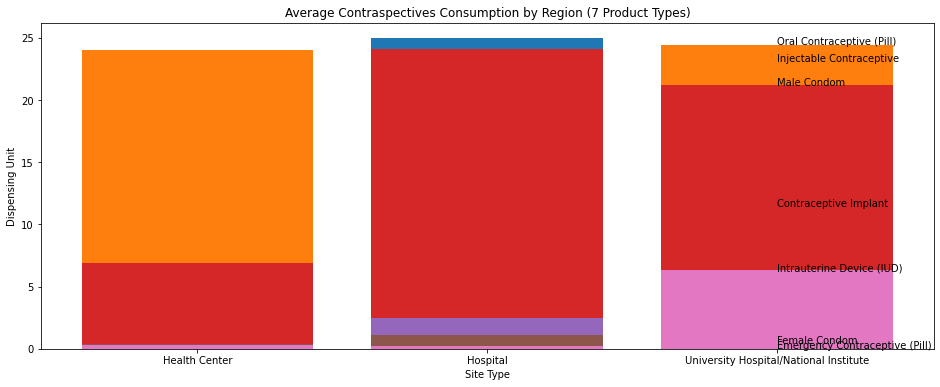

In [271]:
for i in df["product_type"].unique():
    df_temp = df[df["product_type"]==i]
    average_consumption = df_temp.groupby("site_type")["stock_distributed"].mean()
    plt.bar(average_consumption.index, average_consumption.values)
    plt.text(average_consumption.index[-1],average_consumption.values[-1],"{}".format(i))
plt.xlabel("Site Type")
plt.ylabel("Dispensing Unit")
plt.title("Average Contraspectives Consumption by Region (7 Product Types)")

Text(0.5, 1.0, 'Average Contraspectives Consumption by Region (1343 Site_Product)')

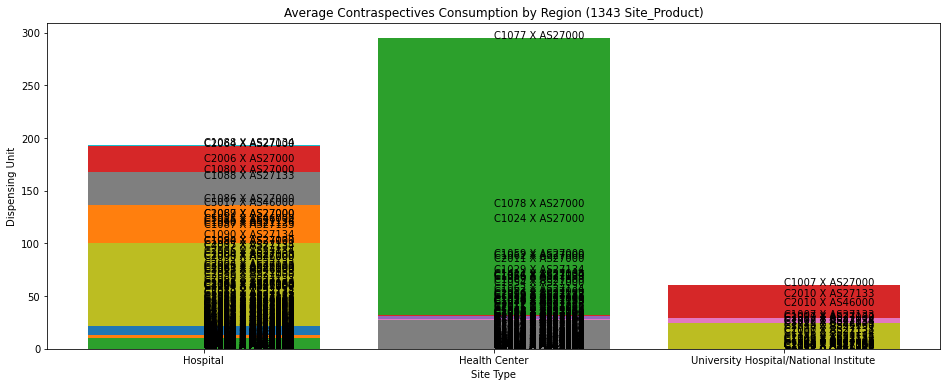

In [273]:
for i in df["site_product"].unique():
    df_temp = df[df["site_product"]==i]
    average_consumption = df_temp.groupby("site_type")["stock_distributed"].mean()
    plt.bar(average_consumption.index, average_consumption.values)
    plt.text(average_consumption.index[-1],average_consumption.values[-1],"{}".format(i))
plt.xlabel("Site Type")
plt.ylabel("Dispensing Unit")
plt.title("Average Contraspectives Consumption by Region (1343 Site_Product)")

Text(0.5, 1.0, 'Average Contraspectives Consumption by Region (1343 Site_Product)')

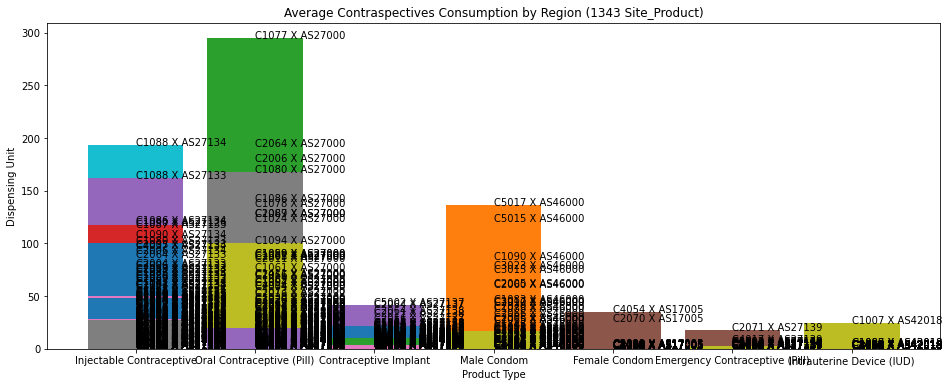

In [274]:
for i in df["site_product"].unique():
    df_temp = df[df["site_product"]==i]
    average_consumption = df_temp.groupby("product_type")["stock_distributed"].mean()
    plt.bar(average_consumption.index, average_consumption.values)
    plt.text(average_consumption.index[-1],average_consumption.values[-1],"{}".format(i))
plt.xlabel("Product Type")
plt.ylabel("Dispensing Unit")
plt.title("Average Contraspectives Consumption by Region (1343 Site_Product)")

## 2.6 Draw trends for consumptions of each site_product

Overall trend for all site_product

In [448]:
consumption_by_site_product = df.groupby(["site_product", "year_month"])["stock_distributed"].mean()
consumption_by_site_product = consumption_by_site_product.reset_index()

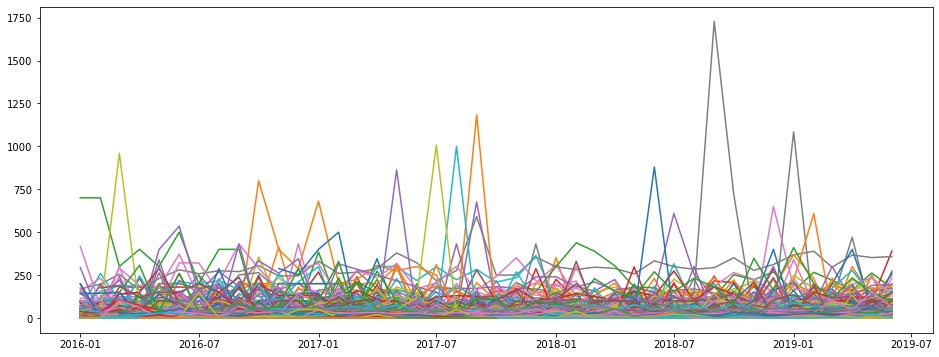

In [449]:
for i in consumption_by_site_product["site_product"].unique():
  temp = consumption_by_site_product[consumption_by_site_product["site_product"]==i]
  plt.plot(temp["year_month"], temp["stock_distributed"])

Individual trend for each site_product

In [341]:
temp = list(df.groupby("site_product"))

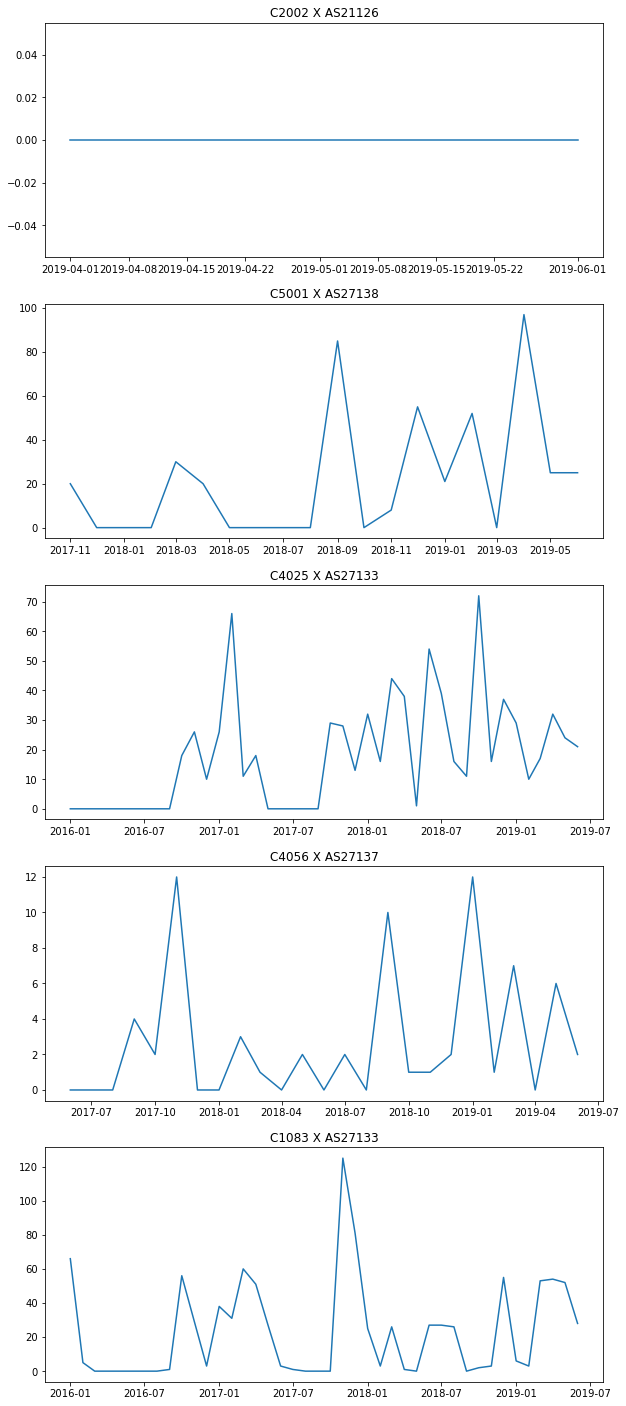

In [344]:
n_plot = 5
indices = np.random.choice(np.arange(0, 1343, 1), size=n_plot, replace=False)

fig, axes = plt.subplots(n_plot, 1, figsize=(10, n_plot*5))
for index, ax in zip(indices, axes):
    ax.plot(temp[index][1].year_month, temp[index][1].stock_distributed)
    ax.set_title("{}".format(temp[index][0]))

trends at different sites for different products

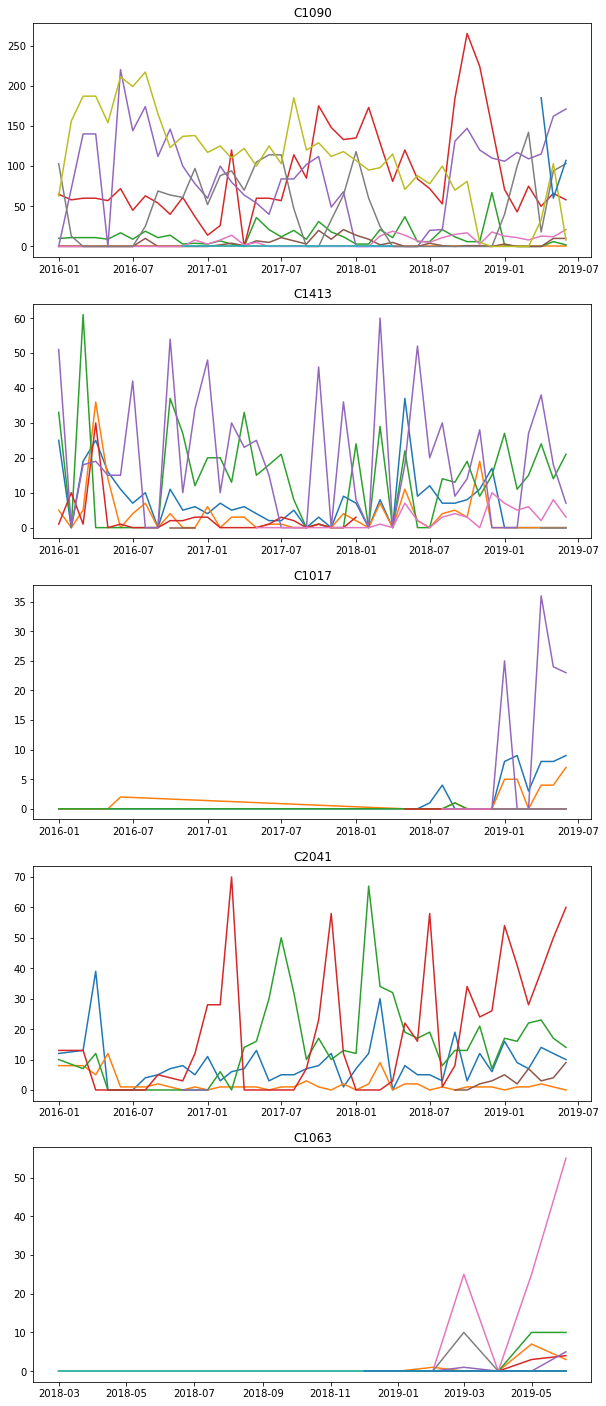

In [474]:
temp = list(df.groupby("site_code"))


n_plot = 5
indices = np.random.choice(np.arange(0, 155, 1), size=n_plot, replace=False)

fig, axes = plt.subplots(n_plot, 1, figsize=(10, n_plot*5))
for index, ax in zip(indices, axes):
    d = temp[index][1]
    for product in d.product_code.unique():
        ax.plot(d[d.product_code==product].year_month, d[d.product_code==product].stock_distributed)
        ax.set_title("{}".format(temp[index][0]))

## 2.7 Check autocorrelation

Check autocorrelation for mean consumptions   
Values are not much correlated.

In [355]:
temp2 = df.groupby("year_month")["stock_distributed"].mean()

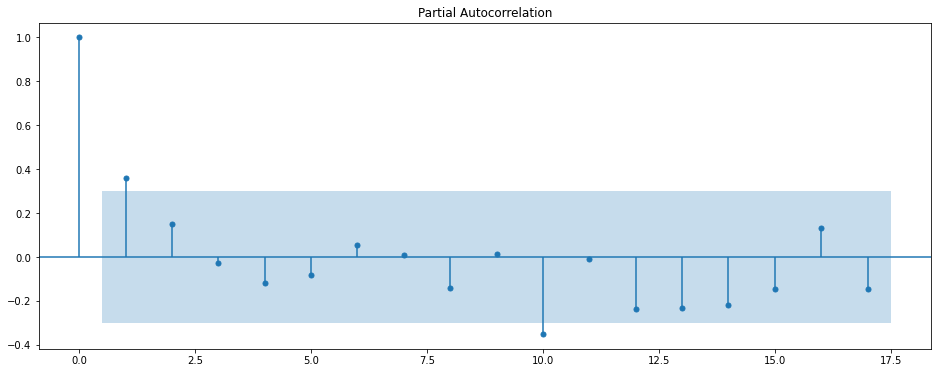

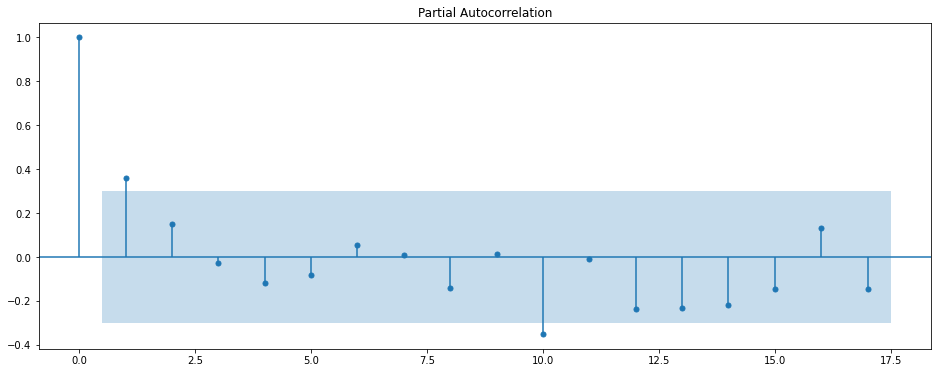

In [356]:
plot_pacf(temp2)

Check individual autocorrelations for each site_product   
Values are not much correlated.

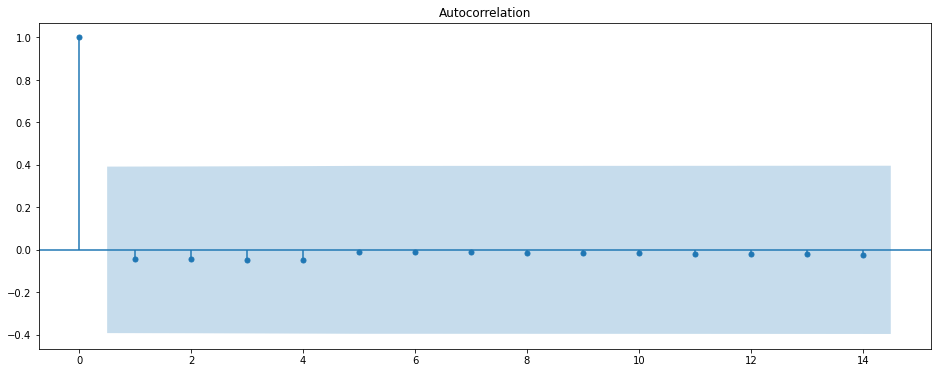

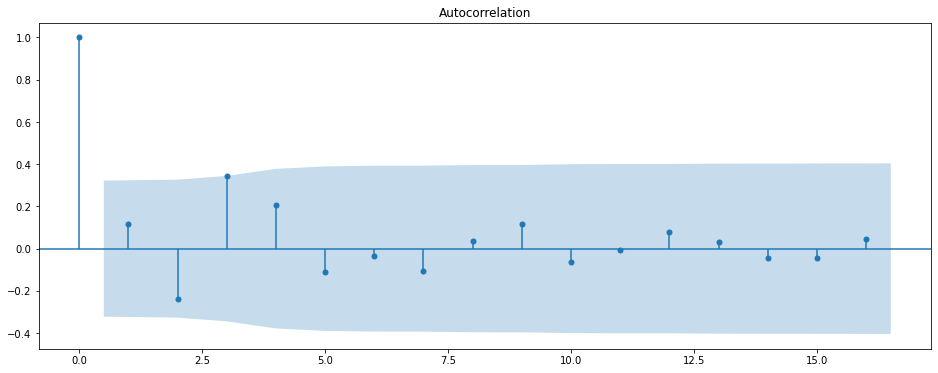

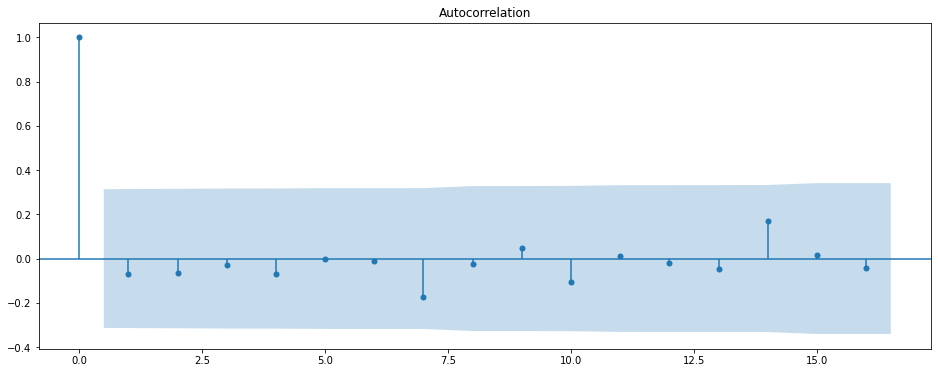

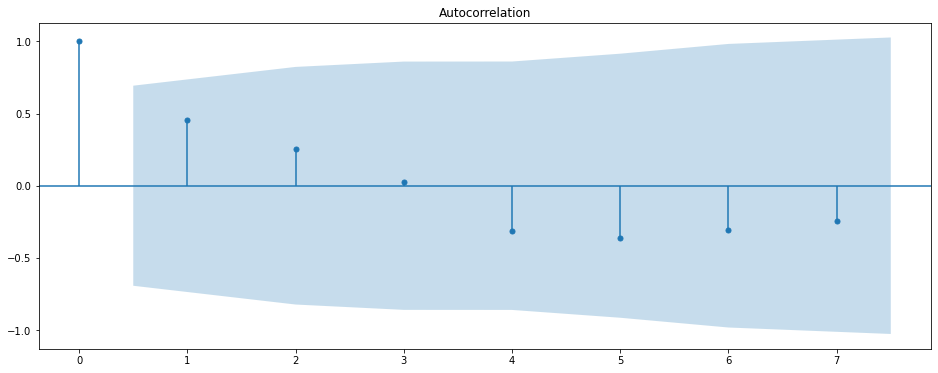

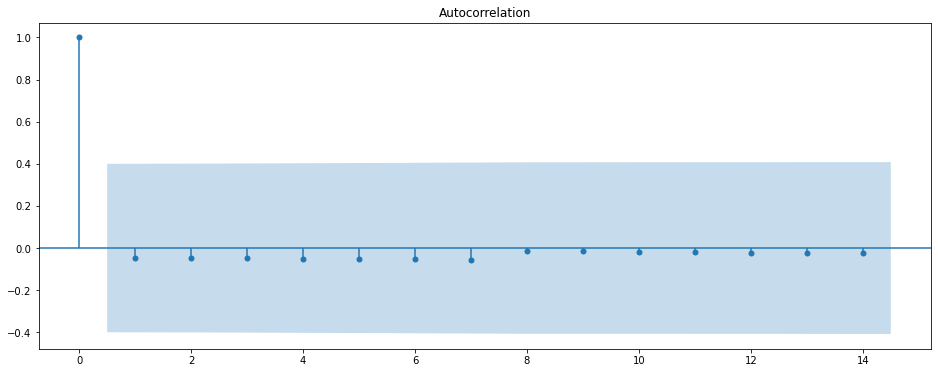

In [358]:
n_plot = 5
indices = np.random.choice(np.arange(0, 1343, 1), size=n_plot, replace=False)

for index, ax in zip(indices, axes):
    plot_acf(temp[index][1].stock_distributed)

## 2.8 Look into situations with outliers

Site and Product which has low stock_initial and high consumption, but order too few. (Need to restock more.)

In [364]:
stock_initial_ordered_problem = df.loc[(df["stock_initial"] < 400) & (df["stock_ordered"] < 400)]
temp = stock_initial_ordered_problem[stock_initial_ordered_problem["stock_distributed"] > 300]
temp = pd.pivot_table(temp, values = "stock_distributed", index = "site_code", columns = "product_code", aggfunc = "mean")
temp

product_code  AS17005  AS27000  AS27132  AS27133  AS27134  AS46000
site_code                                                         
C1066             NaN    676.0      NaN      NaN      NaN      NaN
C1069             NaN    316.0      NaN      NaN      NaN      NaN
C1088             NaN      NaN      NaN    369.0    305.0      NaN
C2011             NaN    330.5    339.0      NaN      NaN      NaN
C2064             NaN    315.0      NaN      NaN      NaN      NaN
C2070           312.5      NaN      NaN      NaN      NaN      NaN
C3023             NaN    330.0      NaN      NaN      NaN      NaN
C5017             NaN      NaN      NaN      NaN      NaN    307.0

Site and Product which has high stock_initial and low consumption, but order too many. (Need to restock less.)

In [365]:
stock_initial_ordered_problem = df.loc[(df["stock_initial"] > 400) & (df["stock_ordered"] > 400)]
temp = stock_initial_ordered_problem[stock_initial_ordered_problem["stock_distributed"] < 300]
temp = pd.pivot_table(temp, values = "stock_distributed", index = "site_code", columns = "product_code", aggfunc = "mean")
temp

product_code     AS27000  AS27134
site_code                        
C1077         255.400000      NaN
C1080         264.000000      NaN
C1086         181.500000      NaN
C1088                NaN    200.0
C2064         178.333333      NaN

## 2.9 Look into situations with product loss at site

The number of losses of products by each category. (Need to take precautions to prevent losses.)

In [275]:
adjustment_df = df.sort_values(by = "stock_adjustment")
adjustment_df = adjustment_df[adjustment_df["stock_adjustment"]<=-100]

In [276]:
for col in ["site_code", "region", "district", "product_name", "site_type", "product_type"]:
    print(col)
    print(adjustment_df[col].value_counts(), "\n")

site_code
C2051    6
C1093    5
C2064    5
C2062    4
C1088    4
        ..
C2063    1
C2049    1
C2002    1
C5019    1
C5016    1
Name: site_code, Length: 72, dtype: int64 

region
ABIDJAN 1-GRANDS PONTS     25
AGNEBY-TIASSA-ME           16
ABIDJAN 2                  13
BELIER                     11
GBOKLE-NAWA-SAN PEDRO      10
GBEKE                       8
SUD-COMOE                   7
PORO-TCHOLOGO-BAGOUE        7
BOUNKANI-GONTOUGO           6
HAUT-SASSANDRA              4
WORODOUGOU-BERE             4
TONKPI                      3
MARAHOUE                    3
HAMBOL                      3
GOH                         3
N'ZI-IFOU-MORONOU           3
CAVALLY-GUEMON              2
INDENIE-DJUABLIN            2
LOH-DJIBOUA                 1
KABADOUGOU-BAFING-FOLON     1
Name: region, dtype: int64 

district
ADJAME-PLATEAU-ATTECOUBE     10
SOUBRE                        7
DIDIEVI                       6
YOPOUGON-OUEST-SONGON         6
ALEPE                         6
GRAND-BASSAM        